Connected to base (Python 3.9.19)

In [ ]:
import numpy as np, scipy, matplotlib.pyplot as plt, sys, pandas as pd
import pickle, seaborn as sns, random, math
from collections import Counter
from itertools import combinations, chain
import matplotlib.backends.backend_pdf, matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["xtick.major.size"] = 10
mpl.rcParams["ytick.major.size"] = 10
# plt.rc('font', size=20)          # controls default text sizes
plt.rcParams["font.family"] = "Arial"
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['gray', 'red', 'lime'])  # -1 = gray, 0 = red, 1 = green
bounds = [-1.5, -0.5, 0.5, 1.5]  # boundaries between categories
norm = BoundaryNorm(bounds, cmap.N)
sys.path.append(r'C:\Users\Han\Documents\MATLAB\han-lab') ## custom to your clone
from projects.memory.behavior import consecutive_stretch
from projects.pyr_reward.placecell import get_tuning_curve, calc_COM_EH, make_tuning_curves_by_trialtype_w_darktime, make_tuning_curves_time_trial_by_trial, make_tuning_curves_time_trial_by_trial_w_darktime, intersect_arrays,make_tuning_curves
from projects.pyr_reward.rewardcell import get_radian_position,\
    get_radian_position_first_lick_after_rew, get_rewzones, get_goal_cells, goal_cell_shuffle
from projects.opto.behavior.behavior import get_success_failure_trials
conddf = pd.read_csv(r"Z:\condition_df\conddf_pyr_goal_cells.csv", index_col=None)
savedst = r'C:\Users\Han\Box\neuro_phd_stuff\han_2023-\pyramidal_cell_paper\panels_main_figures'
savepth = os.path.join(savedst, 'trial_by_trial_tuning_w_com.pdf')
pdf = matplotlib.backends.backend_pdf.PdfPages(savepth)

In [ ]:
import numpy as np, scipy, matplotlib.pyplot as plt, sys, pandas as pd
import pickle, seaborn as sns, random, math
from collections import Counter
from itertools import combinations, chain
import matplotlib.backends.backend_pdf, matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["xtick.major.size"] = 10
mpl.rcParams["ytick.major.size"] = 10
# plt.rc('font', size=20)          # controls default text sizes
plt.rcParams["font.family"] = "Arial"
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['gray', 'red', 'lime'])  # -1 = gray, 0 = red, 1 = green
bounds = [-1.5, -0.5, 0.5, 1.5]  # boundaries between categories
norm = BoundaryNorm(bounds, cmap.N)
sys.path.append(r'C:\Users\Han\Documents\MATLAB\han-lab') ## custom to your clone
from projects.memory.behavior import consecutive_stretch
from projects.pyr_reward.placecell import get_tuning_curve, calc_COM_EH, make_tuning_curves_by_trialtype_w_darktime, make_tuning_curves_time_trial_by_trial, make_tuning_curves_time_trial_by_trial_w_darktime, intersect_arrays,make_tuning_curves
from projects.pyr_reward.rewardcell import get_radian_position,\
    get_radian_position_first_lick_after_rew, get_rewzones, get_goal_cells, goal_cell_shuffle
from projects.opto.behavior.behavior import get_success_failure_trials
conddf = pd.read_csv(r"Z:\condition_df\conddf_pyr_goal_cells.csv", index_col=None)
savedst = r'C:\Users\Han\Box\neuro_phd_stuff\han_2023-\pyramidal_cell_paper\panels_main_figures'
savepth = os.path.join(savedst, 'trial_by_trial_cell_cell_corr.pdf')
pdf = matplotlib.backends.backend_pdf.PdfPages(savepth)

In [ ]:
bins = 150
goal_cm_window=20
dfs = []; lick_dfs = []
# cm_window = [10,20,30,40,50,60,70,80] # cm
# iterate through all animals
ii=130
day = conddf.days.values[ii]
animal = conddf.animals.values[ii]
if animal=='e145' or animal=='e139': pln=2 
else: pln=0
params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane{pln}_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 
        'timedFF', 'ybinned', 'VR', 'forwardvel', 'trialnum', 'rewards', 'iscell', 'bordercells',
        'stat', 'licks'])
VR = fall['VR'][0][0][()]
scalingf = VR['scalingFACTOR'][0][0]
try:
        rewsize = VR['settings']['rewardZone'][0][0][0][0]/scalingf        
except:
        rewsize = 10
ybinned = fall['ybinned'][0]/scalingf
track_length=180/scalingf    
forwardvel = fall['forwardvel'][0]    
changeRewLoc = np.hstack(fall['changeRewLoc'])
trialnum=fall['trialnum'][0]
rewards = fall['rewards'][0]
lick=fall['licks'][0]
time=fall['timedFF'][0]
if animal=='e145':
        ybinned=ybinned[:-1]
        forwardvel=forwardvel[:-1]
        changeRewLoc=changeRewLoc[:-1]
        trialnum=trialnum[:-1]
        rewards=rewards[:-1]
        lick=lick[:-1]
        time=time[:-1]
# set vars
eps = np.where(changeRewLoc>0)[0];rewlocs = changeRewLoc[eps]/scalingf;eps = np.append(eps, len(changeRewLoc))
rz = get_rewzones(rewlocs,1/scalingf)       
# get average success rate
rates = []
for ep in range(len(eps)-1):
        eprng = range(eps[ep],eps[ep+1])
        success, fail, str_trials, ftr_trials, ttr, \
        total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        rates.append(success/total_trials)
rate=np.nanmean(np.array(rates))
# dark time params
track_length_dt = 550 # cm estimate based on 99.9% of ypos
track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
bins_dt=150 
bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
# added to get anatomical info
# takes time
fall_fc3 = scipy.io.loadmat(params_pth, variable_names=['Fc3', 'dFF'])
Fc3 = fall_fc3['Fc3']
dFF = fall_fc3['dFF']
Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool))]
dFF = dFF[:, ((fall['iscell'][:,0]).astype(bool))]
skew = scipy.stats.skew(dFF, nan_policy='omit', axis=0)
Fc3 = Fc3[:, skew>2] # only keep cells with skew greateer than 2

Y:\analysis\fmats\e201\days\e201_day050_plane0_Fall.mat


In [ ]:
bins = 150
goal_cm_window=20
dfs = []; lick_dfs = []
# cm_window = [10,20,30,40,50,60,70,80] # cm
# iterate through all animals
ii=130
day = conddf.days.values[ii]
animal = conddf.animals.values[ii]
if animal=='e145' or animal=='e139': pln=2 
else: pln=0
params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane{pln}_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 
        'timedFF', 'ybinned', 'VR', 'forwardvel', 'trialnum', 'rewards', 'iscell', 'bordercells',
        'stat', 'licks'])
VR = fall['VR'][0][0][()]
scalingf = VR['scalingFACTOR'][0][0]
try:
        rewsize = VR['settings']['rewardZone'][0][0][0][0]/scalingf        
except:
        rewsize = 10
ybinned = fall['ybinned'][0]/scalingf
track_length=180/scalingf    
forwardvel = fall['forwardvel'][0]    
changeRewLoc = np.hstack(fall['changeRewLoc'])
trialnum=fall['trialnum'][0]
rewards = fall['rewards'][0]
lick=fall['licks'][0]
time=fall['timedFF'][0]
if animal=='e145':
   ybinned=ybinned[:-1]
   forwardvel=forwardvel[:-1]
   changeRewLoc=changeRewLoc[:-1]
   trialnum=trialnum[:-1]
   rewards=rewards[:-1]
   lick=lick[:-1]
   time=time[:-1]
# set vars
eps = np.where(changeRewLoc>0)[0];rewlocs = changeRewLoc[eps]/scalingf;eps = np.append(eps, len(changeRewLoc))
rz = get_rewzones(rewlocs,1/scalingf)       
# dark time params
track_length_dt = 550 # cm estimate based on 99.9% of ypos
track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
bins_dt=150 
bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
# added to get anatomical info
# takes time

fall_fc3 = scipy.io.loadmat(params_pth, variable_names=['Fc3', 'dFF'])
Fc3 = fall_fc3['Fc3']
dFF = fall_fc3['dFF']
Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
dFF = dFF[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
skew = scipy.stats.skew(dFF, nan_policy='omit', axis=0)
#if pc in all but 1
pc_bool = np.sum(pcs,axis=0)>=len(eps)-2
# looser restrictions
pc_bool = np.sum(pcs,axis=0)>=1        
if animal=='e200' or animal=='e217' or animal=='z17':
   Fc3 = Fc3[:,((skew>1)&pc_bool)]
else:
   Fc3 = Fc3[:,((skew>2)&pc_bool)] # only keep cells with skew greater than 2
# if no cells pass these crit
skew_thres_range=np.arange(0,1.6,0.1)[::-1]
iii=0
while Fc3.shape[1]==0:      
   iii+=1
   print('************************0 cells skew > 2************************')
   Fc3 = fall_fc3['Fc3']                        
   Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
   Fc3 = Fc3[:, (skew>skew_thres_range[iii])&pc_bool]
if Fc3.shape[1]>0:
   print('#############making tcs#############\n')
   tcs_correct_abs, coms_correct_abs,tcs_fail_abs, coms_fail_abs = make_tuning_curves(eps,rewlocs,ybinned,
   Fc3,trialnum,rewards,forwardvel,
   rewsize,bin_size) # last 5 trials

   track_length_dt = 550 # cm estimate based on 99.9% of ypos
   track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
   bins_dt=150 
   bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
   tcs_correct, coms_correct, tcs_fail, coms_fail, ybinned_dt, rad = make_tuning_curves_by_trialtype_w_darktime(eps,rewlocs,rewsize,ybinned,time,lick,Fc3,trialnum, rewards,forwardvel,scalingf,bin_size_dt,
         bins=bins_dt,lasttr=8) 
   goal_window = 20*(2*np.pi/track_length) # cm converted to rad
   coms_rewrel = np.array([com-np.pi for com in coms_correct])
   # account for cells that move to the end/front
   # Define a small window around pi (e.g., epsilon)
   epsilon = .7 # 20 cm
   # Find COMs near pi and shift to -pi
   com_loop_w_in_window = []
   for pi,p in enumerate(perm):
      for cll in range(coms_rewrel.shape[1]):
         com1_rel = coms_rewrel[p[0],cll]
         com2_rel = coms_rewrel[p[1],cll]
         # print(com1_rel,com2_rel,com_diff)
         if ((abs(com1_rel - np.pi) < epsilon) and 
         (abs(com2_rel + np.pi) < epsilon)):
                  com_loop_w_in_window.append(cll)
   # get abs value instead
   coms_rewrel[:,com_loop_w_in_window]=abs(coms_rewrel[:,com_loop_w_in_window])
   com_remap = np.array([(coms_rewrel[perm[jj][0]]-coms_rewrel[perm[jj][1]]) for jj in range(len(perm))])        
   com_goal = [np.where((comr<goal_window) & (comr>-goal_window))[0] for comr in com_remap]
   com_goal=[xx for xx in com_goal if len(xx)>0]
   if len(com_goal)>0:
      goal_cells = np.unique(np.concatenate(com_goal))
   else:
      goal_cells=[]
   # get cells that maintain their coms across at least 2 epochs
   place_window = 20 # cm converted to rad                
   com_per_ep = np.array([(coms_correct_abs[perm[jj][0]]-coms_correct_abs[perm[jj][1]]) for jj in range(len(perm))])        
   compc = [np.where((comr<place_window) & (comr>-place_window))[0] for comr in com_per_ep]
   # get cells across all epochs that meet crit
   pcs = np.unique(np.concatenate(compc))
   compc=[xx for xx in compc if len(xx)>0]
   if len(compc)>0:
      pcs_all = np.unique(np.concatenate(compc))
      # exclude goal cells
      pcs_all=[xx for xx in pcs_all if xx not in goal_cells]
   else:
      pcs_all=[]      

Y:\analysis\fmats\e201\days\e201_day050_plane0_Fall.mat


NameError: name 'pcs' is not defined

In [ ]:
pcs=fall['putative_pcs'][0]

KeyError: 'putative_pcs'

In [ ]:
fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 
   'timedFF', 'ybinned', 'VR', 'forwardvel', 'trialnum', 'rewards', 'iscell', 'bordercells',
   'stat', 'licks','putative_pcs'])

In [ ]:
pcs=fall['putative_pcs'][0]

In [ ]:
pcs

array([array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
               1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
               0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
               0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
               1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
               1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
               1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
               0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
               0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
               0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
               0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
               0, 0, 1, 0, 1

In [ ]:
pcs=fall['putative_pcs'][0][0]

In [ ]:
pcs

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 

In [ ]:
pcs.shape

(1, 985)

In [ ]:
pcs=fall['putative_pcs'][0]

In [ ]:
pcs.shape

(3,)

In [ ]:
pcs=np.stack(fall['putative_pcs'][0])

In [ ]:
pcs.shape

(3, 1, 985)

In [ ]:
pcs=np.squeeze(np.stack(fall['putative_pcs'][0]))

In [ ]:
pcs.shape

(3, 985)

In [ ]:
bins = 150
goal_cm_window=20
dfs = []; lick_dfs = []
# cm_window = [10,20,30,40,50,60,70,80] # cm
# iterate through all animals
ii=130
day = conddf.days.values[ii]
animal = conddf.animals.values[ii]
if animal=='e145' or animal=='e139': pln=2 
else: pln=0
params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane{pln}_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 
   'timedFF', 'ybinned', 'VR', 'forwardvel', 'trialnum', 'rewards', 'iscell', 'bordercells',
   'stat', 'licks','putative_pcs'])
VR = fall['VR'][0][0][()]
pcs=np.squeeze(np.stack(fall['putative_pcs'][0]))
scalingf = VR['scalingFACTOR'][0][0]
try:
        rewsize = VR['settings']['rewardZone'][0][0][0][0]/scalingf        
except:
        rewsize = 10
ybinned = fall['ybinned'][0]/scalingf
track_length=180/scalingf    
forwardvel = fall['forwardvel'][0]    
changeRewLoc = np.hstack(fall['changeRewLoc'])
trialnum=fall['trialnum'][0]
rewards = fall['rewards'][0]
lick=fall['licks'][0]
time=fall['timedFF'][0]
if animal=='e145':
   ybinned=ybinned[:-1]
   forwardvel=forwardvel[:-1]
   changeRewLoc=changeRewLoc[:-1]
   trialnum=trialnum[:-1]
   rewards=rewards[:-1]
   lick=lick[:-1]
   time=time[:-1]
# set vars
eps = np.where(changeRewLoc>0)[0];rewlocs = changeRewLoc[eps]/scalingf;eps = np.append(eps, len(changeRewLoc))
rz = get_rewzones(rewlocs,1/scalingf)       
# dark time params
track_length_dt = 550 # cm estimate based on 99.9% of ypos
track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
bins_dt=150 
bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
# added to get anatomical info
# takes time

fall_fc3 = scipy.io.loadmat(params_pth, variable_names=['Fc3', 'dFF'])
Fc3 = fall_fc3['Fc3']
dFF = fall_fc3['dFF']
Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
dFF = dFF[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
skew = scipy.stats.skew(dFF, nan_policy='omit', axis=0)
#if pc in all but 1
pc_bool = np.sum(pcs,axis=0)>=len(eps)-2
# looser restrictions
pc_bool = np.sum(pcs,axis=0)>=1        
if animal=='e200' or animal=='e217' or animal=='z17':
   Fc3 = Fc3[:,((skew>1)&pc_bool)]
else:
   Fc3 = Fc3[:,((skew>2)&pc_bool)] # only keep cells with skew greater than 2
# if no cells pass these crit
skew_thres_range=np.arange(0,1.6,0.1)[::-1]
iii=0
while Fc3.shape[1]==0:      
   iii+=1
   print('************************0 cells skew > 2************************')
   Fc3 = fall_fc3['Fc3']                        
   Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
   Fc3 = Fc3[:, (skew>skew_thres_range[iii])&pc_bool]
if Fc3.shape[1]>0:
   print('#############making tcs#############\n')
   tcs_correct_abs, coms_correct_abs,tcs_fail_abs, coms_fail_abs = make_tuning_curves(eps,rewlocs,ybinned,
   Fc3,trialnum,rewards,forwardvel,
   rewsize,bin_size) # last 5 trials

   track_length_dt = 550 # cm estimate based on 99.9% of ypos
   track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
   bins_dt=150 
   bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
   tcs_correct, coms_correct, tcs_fail, coms_fail, ybinned_dt, rad = make_tuning_curves_by_trialtype_w_darktime(eps,rewlocs,rewsize,ybinned,time,lick,Fc3,trialnum, rewards,forwardvel,scalingf,bin_size_dt,
         bins=bins_dt,lasttr=8) 
   goal_window = 20*(2*np.pi/track_length) # cm converted to rad
   coms_rewrel = np.array([com-np.pi for com in coms_correct])
   # account for cells that move to the end/front
   # Define a small window around pi (e.g., epsilon)
   epsilon = .7 # 20 cm
   # Find COMs near pi and shift to -pi
   com_loop_w_in_window = []
   for pi,p in enumerate(perm):
      for cll in range(coms_rewrel.shape[1]):
         com1_rel = coms_rewrel[p[0],cll]
         com2_rel = coms_rewrel[p[1],cll]
         # print(com1_rel,com2_rel,com_diff)
         if ((abs(com1_rel - np.pi) < epsilon) and 
         (abs(com2_rel + np.pi) < epsilon)):
                  com_loop_w_in_window.append(cll)
   # get abs value instead
   coms_rewrel[:,com_loop_w_in_window]=abs(coms_rewrel[:,com_loop_w_in_window])
   com_remap = np.array([(coms_rewrel[perm[jj][0]]-coms_rewrel[perm[jj][1]]) for jj in range(len(perm))])        
   com_goal = [np.where((comr<goal_window) & (comr>-goal_window))[0] for comr in com_remap]
   com_goal=[xx for xx in com_goal if len(xx)>0]
   if len(com_goal)>0:
      goal_cells = np.unique(np.concatenate(com_goal))
   else:
      goal_cells=[]
   # get cells that maintain their coms across at least 2 epochs
   place_window = 20 # cm converted to rad                
   com_per_ep = np.array([(coms_correct_abs[perm[jj][0]]-coms_correct_abs[perm[jj][1]]) for jj in range(len(perm))])        
   compc = [np.where((comr<place_window) & (comr>-place_window))[0] for comr in com_per_ep]
   # get cells across all epochs that meet crit
   pcs = np.unique(np.concatenate(compc))
   compc=[xx for xx in compc if len(xx)>0]
   if len(compc)>0:
      pcs_all = np.unique(np.concatenate(compc))
      # exclude goal cells
      pcs_all=[xx for xx in pcs_all if xx not in goal_cells]
   else:
      pcs_all=[]      

Y:\analysis\fmats\e201\days\e201_day050_plane0_Fall.mat
#############making tcs#############



NameError: name 'bin_size' is not defined

In [ ]:
bins = 150
goal_cm_window=20
dfs = []; lick_dfs = []
# cm_window = [10,20,30,40,50,60,70,80] # cm
# iterate through all animals
ii=130
day = conddf.days.values[ii]
animal = conddf.animals.values[ii]
if animal=='e145' or animal=='e139': pln=2 
else: pln=0
params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane{pln}_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 
   'timedFF', 'ybinned', 'VR', 'forwardvel', 'trialnum', 'rewards', 'iscell', 'bordercells',
   'stat', 'licks','putative_pcs'])
VR = fall['VR'][0][0][()]
pcs=np.squeeze(np.stack(fall['putative_pcs'][0]))
scalingf = VR['scalingFACTOR'][0][0]
try:
        rewsize = VR['settings']['rewardZone'][0][0][0][0]/scalingf        
except:
        rewsize = 10
ybinned = fall['ybinned'][0]/scalingf
track_length=180/scalingf    
forwardvel = fall['forwardvel'][0]    
changeRewLoc = np.hstack(fall['changeRewLoc'])
trialnum=fall['trialnum'][0]
rewards = fall['rewards'][0]
lick=fall['licks'][0]
time=fall['timedFF'][0]
if animal=='e145':
   ybinned=ybinned[:-1]
   forwardvel=forwardvel[:-1]
   changeRewLoc=changeRewLoc[:-1]
   trialnum=trialnum[:-1]
   rewards=rewards[:-1]
   lick=lick[:-1]
   time=time[:-1]
# set vars
eps = np.where(changeRewLoc>0)[0];rewlocs = changeRewLoc[eps]/scalingf;eps = np.append(eps, len(changeRewLoc))
rz = get_rewzones(rewlocs,1/scalingf)       
# dark time params
track_length_dt = 550 # cm estimate based on 99.9% of ypos
track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
bins_dt=150 
bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
# added to get anatomical info
# takes time

fall_fc3 = scipy.io.loadmat(params_pth, variable_names=['Fc3', 'dFF'])
Fc3 = fall_fc3['Fc3']
dFF = fall_fc3['dFF']
Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
dFF = dFF[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
skew = scipy.stats.skew(dFF, nan_policy='omit', axis=0)
#if pc in all but 1
pc_bool = np.sum(pcs,axis=0)>=len(eps)-2
# looser restrictions
pc_bool = np.sum(pcs,axis=0)>=1        
if animal=='e200' or animal=='e217' or animal=='z17':
   Fc3 = Fc3[:,((skew>1)&pc_bool)]
else:
   Fc3 = Fc3[:,((skew>2)&pc_bool)] # only keep cells with skew greater than 2
# if no cells pass these crit
if Fc3.shape[1]>0:
   print('#############making tcs#############\n')
   bin_size=3
   tcs_correct_abs, coms_correct_abs,tcs_fail_abs, coms_fail_abs = make_tuning_curves(eps,rewlocs,ybinned,
   Fc3,trialnum,rewards,forwardvel,
   rewsize,bin_size) # last 5 trials

   track_length_dt = 550 # cm estimate based on 99.9% of ypos
   track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
   bins_dt=150 
   bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
   tcs_correct, coms_correct, tcs_fail, coms_fail, ybinned_dt, rad = make_tuning_curves_by_trialtype_w_darktime(eps,rewlocs,rewsize,ybinned,time,lick,Fc3,trialnum, rewards,forwardvel,scalingf,bin_size_dt,
         bins=bins_dt,lasttr=8) 
   goal_window = 20*(2*np.pi/track_length) # cm converted to rad
   coms_rewrel = np.array([com-np.pi for com in coms_correct])
   # account for cells that move to the end/front
   # Define a small window around pi (e.g., epsilon)
   epsilon = .7 # 20 cm
   # Find COMs near pi and shift to -pi
   com_loop_w_in_window = []
   for pi,p in enumerate(perm):
      for cll in range(coms_rewrel.shape[1]):
         com1_rel = coms_rewrel[p[0],cll]
         com2_rel = coms_rewrel[p[1],cll]
         # print(com1_rel,com2_rel,com_diff)
         if ((abs(com1_rel - np.pi) < epsilon) and 
         (abs(com2_rel + np.pi) < epsilon)):
                  com_loop_w_in_window.append(cll)
   # get abs value instead
   coms_rewrel[:,com_loop_w_in_window]=abs(coms_rewrel[:,com_loop_w_in_window])
   com_remap = np.array([(coms_rewrel[perm[jj][0]]-coms_rewrel[perm[jj][1]]) for jj in range(len(perm))])        
   com_goal = [np.where((comr<goal_window) & (comr>-goal_window))[0] for comr in com_remap]
   com_goal=[xx for xx in com_goal if len(xx)>0]
   if len(com_goal)>0:
      goal_cells = np.unique(np.concatenate(com_goal))
   else:
      goal_cells=[]
   # get cells that maintain their coms across at least 2 epochs
   place_window = 20 # cm converted to rad                
   com_per_ep = np.array([(coms_correct_abs[perm[jj][0]]-coms_correct_abs[perm[jj][1]]) for jj in range(len(perm))])        
   compc = [np.where((comr<place_window) & (comr>-place_window))[0] for comr in com_per_ep]
   # get cells across all epochs that meet crit
   pcs = np.unique(np.concatenate(compc))
   compc=[xx for xx in compc if len(xx)>0]
   if len(compc)>0:
      pcs_all = np.unique(np.concatenate(compc))
      # exclude goal cells
      pcs_all=[xx for xx in pcs_all if xx not in goal_cells]
   else:
      pcs_all=[]      

Y:\analysis\fmats\e201\days\e201_day050_plane0_Fall.mat
#############making tcs#############



C:\Users\Han\Documents\MATLAB\han-lab\projects\pyr_reward\placecell.py:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
C:\Users\Han\Documents\MATLAB\han-lab\projects\pyr_reward\placecell.py:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
C:\Users\Han\Documents\MATLAB\han-lab\projects\pyr_reward\placecell.py:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
C:\Users\Han\Documents\MATLAB\han-lab\projects\pyr_reward\placecell.py:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
C:\Users\Han\Documents\MATLAB\han-lab\projects\pyr_reward\placecell.py:813: RuntimeWarni

NameError: name 'perm' is not defined

In [ ]:
perm

NameError: name 'perm' is not defined

In [ ]:
perm = list(combinations(range(len(coms_correct)), 2))

In [ ]:
perm = list(combinations(range(len(coms_correct)), 2)) 
# account for cells that move to the end/front
# Define a small window around pi (e.g., epsilon)
epsilon = .7 # 20 cm
# Find COMs near pi and shift to -pi
com_loop_w_in_window = []
for pi,p in enumerate(perm):
   for cll in range(coms_rewrel.shape[1]):
      com1_rel = coms_rewrel[p[0],cll]
      com2_rel = coms_rewrel[p[1],cll]
      # print(com1_rel,com2_rel,com_diff)
      if ((abs(com1_rel - np.pi) < epsilon) and 
      (abs(com2_rel + np.pi) < epsilon)):
               com_loop_w_in_window.append(cll)
# get abs value instead
coms_rewrel[:,com_loop_w_in_window]=abs(coms_rewrel[:,com_loop_w_in_window])
com_remap = np.array([(coms_rewrel[perm[jj][0]]-coms_rewrel[perm[jj][1]]) for jj in range(len(perm))])        
com_goal = [np.where((comr<goal_window) & (comr>-goal_window))[0] for comr in com_remap]
com_goal=[xx for xx in com_goal if len(xx)>0]
if len(com_goal)>0:
   goal_cells = np.unique(np.concatenate(com_goal))
else:
   goal_cells=[]
# get cells that maintain their coms across at least 2 epochs
place_window = 20 # cm converted to rad                
com_per_ep = np.array([(coms_correct_abs[perm[jj][0]]-coms_correct_abs[perm[jj][1]]) for jj in range(len(perm))])        
compc = [np.where((comr<place_window) & (comr>-place_window))[0] for comr in com_per_ep]
# get cells across all epochs that meet crit
pcs = np.unique(np.concatenate(compc))
compc=[xx for xx in compc if len(xx)>0]
if len(compc)>0:
   pcs_all = np.unique(np.concatenate(compc))
   # exclude goal cells
   pcs_all=[xx for xx in pcs_all if xx not in goal_cells]
else:

IndentationError: expected an indented block (<ipython-input-22-bd2f21f1babb>, line 35)

In [ ]:
perm = list(combinations(range(len(coms_correct)), 2)) 
# account for cells that move to the end/front
# Define a small window around pi (e.g., epsilon)
epsilon = .7 # 20 cm
# Find COMs near pi and shift to -pi
com_loop_w_in_window = []
for pi,p in enumerate(perm):
   for cll in range(coms_rewrel.shape[1]):
      com1_rel = coms_rewrel[p[0],cll]
      com2_rel = coms_rewrel[p[1],cll]
      # print(com1_rel,com2_rel,com_diff)
      if ((abs(com1_rel - np.pi) < epsilon) and 
      (abs(com2_rel + np.pi) < epsilon)):
               com_loop_w_in_window.append(cll)
# get abs value instead
coms_rewrel[:,com_loop_w_in_window]=abs(coms_rewrel[:,com_loop_w_in_window])
com_remap = np.array([(coms_rewrel[perm[jj][0]]-coms_rewrel[perm[jj][1]]) for jj in range(len(perm))])        
com_goal = [np.where((comr<goal_window) & (comr>-goal_window))[0] for comr in com_remap]
com_goal=[xx for xx in com_goal if len(xx)>0]
if len(com_goal)>0:
   goal_cells = np.unique(np.concatenate(com_goal))
else:
   goal_cells=[]
# get cells that maintain their coms across at least 2 epochs
place_window = 20 # cm converted to rad                
com_per_ep = np.array([(coms_correct_abs[perm[jj][0]]-coms_correct_abs[perm[jj][1]]) for jj in range(len(perm))])        
compc = [np.where((comr<place_window) & (comr>-place_window))[0] for comr in com_per_ep]
# get cells across all epochs that meet crit
pcs = np.unique(np.concatenate(compc))
compc=[xx for xx in compc if len(xx)>0]
if len(compc)>0:
   pcs_all = np.unique(np.concatenate(compc))
   # exclude goal cells
   pcs_all=[xx for xx in pcs_all if xx not in goal_cells]
else:
   pcs_all=[]

In [ ]:
pcs_all

[0,
 3,
 13,
 16,
 17,
 20,
 22,
 25,
 26,
 28,
 36,
 42,
 43,
 45,
 49,
 51,
 52,
 54,
 58,
 61,
 63,
 67,
 75,
 81,
 83,
 92,
 99,
 104,
 106,
 111,
 112,
 115,
 116,
 118,
 128,
 132,
 134,
 138,
 139,
 142,
 150,
 152,
 178,
 187,
 188,
 192,
 198,
 200,
 203,
 206,
 212,
 215,
 219,
 221,
 223,
 226,
 231,
 240,
 242,
 246,
 251,
 261,
 266,
 271,
 277,
 284,
 291,
 299,
 300,
 304,
 308,
 313,
 318]

In [ ]:
goal_cells

array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,
        18,  21,  23,  24,  29,  30,  31,  32,  33,  34,  35,  37,  38,
        39,  41,  44,  46,  47,  48,  50,  53,  55,  56,  57,  59,  60,
        62,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  76,  77,
        78,  79,  80,  82,  84,  85,  86,  87,  88,  89,  90,  91,  93,
        94,  95,  96,  98, 100, 101, 102, 103, 105, 107, 109, 110, 113,
       114, 119, 120, 121, 123, 124, 125, 126, 127, 129, 130, 133, 136,
       137, 140, 141, 143, 145, 146, 147, 148, 149, 151, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169,
       170, 172, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185,
       186, 189, 190, 191, 193, 195, 196, 197, 199, 201, 204, 205, 208,
       209, 210, 211, 213, 214, 216, 217, 218, 220, 222, 224, 225, 228,
       229, 230, 232, 233, 234, 235, 236, 237, 239, 243, 244, 245, 247,
       248, 249, 250, 252, 253, 255, 256, 257, 258, 259, 262, 26

In [ ]:
fc3_trial =[]   
ep_trials = []
# 50 msec time bin
# no binning for now
bin_size = int(0.05 * 1/np.nanmedian(np.diff(time)))  # number of frames in 100ms
for ep in range(len(eps)-1):
   eprng = np.arange(eps[ep],eps[ep+1])
   unique_trials = np.unique(trialnum[eprng])
   ypos = ybinned[eprng]
   for tt,tr in enumerate(unique_trials):
      tr_mask = trialnum[eprng] == tr
      fc_trial = Fc3[eprng][tr_mask, :]                  # shape (t, n_cells)
      # remove later activity
      ypos_tr = ypos[tr_mask]
      fc_trial[(ypos_tr<3)]=0
      if fc_trial.shape[0] >= 10:#; dont exclude probes for now
         fc_trial_binned = fc_trial
         fc3_trial.append(fc_trial_binned)
         ep_trials.append(ep)

In [ ]:
fc3_trial

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ],
        [-0.        ,  0.71469079,  0.        , ..., -0.        ,
          0.        ,  0.        ],
        [-0.        ,  1.46483837,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-0.        ,  1.46989177,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -

In [ ]:
fc3_trial[0].shape

(504, 324)

In [ ]:
Fc3.shape

(50000, 324)

In [ ]:
cll=0
cell_cell_corr = [scipy.stats.pearsonr(fc3_trial[0,cll],fc3_trial[tr,cll]) for tr in len(fc3_trial)]

TypeError: 'int' object is not iterable

In [ ]:
cll=0
cell_cell_corr = [scipy.stats.pearsonr(fc3_trial[0,cll],fc3_trial[tr,cll]) for tr in range(len(fc3_trial))]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
cll

0

In [ ]:
tr

11

In [ ]:
cell_cell_corr = [scipy.stats.pearsonr(fc3_trial[0][:,cll],fc3_trial[tr][:,cll]) for tr in range(len(fc3_trial))]

<ipython-input-34-dda65a215387>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [scipy.stats.pearsonr(fc3_trial[0][:,cll],fc3_trial[tr][:,cll]) for tr in range(len(fc3_trial))]


ValueError: x and y must have the same length.

In [ ]:
trialstates, licks_all, tcs_all, coms_all, ypos_max_all_ep, vels_all =make_tuning_curves_time_trial_by_trial_w_darktime(eps, rewlocs, rewsize, lick, ybinned, time, Fc3, trialnum, rewards, forwardvel, scalingf,bins=150)

TypeError: get_radian_position_first_lick_after_rew_w_dt() missing 1 required positional argument: 'trialnum'

In [ ]:
import numpy as np, math, scipy
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from scipy.stats import pearsonr, ranksums
import numpy as np, h5py, scipy, matplotlib.pyplot as plt, sys, pandas as pd
import pickle, seaborn as sns, random
from sklearn.cluster import KMeans
from scipy.signal.windows import gaussian
from scipy.ndimage import label
sys.path.append(r'C:\Users\Han\Documents\MATLAB\han-lab') ## custom to your clone
from projects.opto.behavior.behavior import get_success_failure_trials

def get_behavior_tuning_curve(ybinned, beh, bins=270):
    """
    Plot a lick tuning curve given a dataframe with position and lick columns.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - position_col: name of the column in df that contains the position data.
    - lick_col: name of the column in df that contains the lick binary variable (1 for lick, 0 for no lick).
    - bins: number of bins to divide the position data into for the curve.
    """
    df = pd.DataFrame()
    df['position'] = ybinned
    df['beh'] = beh
    # Discretize the position data into bins
    df['position_bin'] = pd.cut(df['position'], bins=bins, labels=False)
    
    # Calculate the lick probability for each bin
    grouped = df.groupby('position_bin')['beh'].agg(['mean', 'count']).reset_index()
    beh_probability = grouped['mean']  # This is the mean of the binary lick variable, which represents probability
    
    return np.array(beh_probability)


def get_tuning_curve(ybinned, f, bins=270):
    """
    """
    df = pd.DataFrame()
    df['position'] = ybinned
    df['f'] = f
    # Discretize the position data into bins
    df['position_bin'] = pd.cut(df['position'], bins=bins, labels=False)
    
    grouped = df.groupby('position_bin')['f'].agg(['mean', 'count']).reset_index()
    f_tc = np.ones(bins)*np.nan
    f_tc[:np.array(grouped['mean'].shape[0])] = grouped['mean'] 
    
    return np.array(f_tc)


def make_tuning_curves_radians_trial_by_trial(eps,rewlocs,lick,ybinned,rad,Fc3,trialnum,rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90):
    trialstates = []; licks = []; tcs = []; coms = []    
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        # excludes probe trials
        success, fail, strials, ftrials, ttr, \
        total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        # make sure mouse did full trial & includes probes
        trials = [xx for xx in np.unique(trialnum[eprng]) if np.sum(trialnum[eprng]==xx)>100]
        trialstate = np.ones(len(trials))*-1
        # check if original trial num is correct or not
        trialstate[[xx for xx,t in enumerate(trials) if t in strials]] = 1
        trialstate[[xx for xx,t in enumerate(trials) if t in ftrials]] = 0
        trialstates.append(trialstate)
        F = Fc3[eprng,:]            
        # moving_middle,stop = get_moving_time_V3(forwardvel[eprng], 5, 5, 10)
        # simpler metric to get moving time
        moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        # overwrite velocity filter
        moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F = F[moving_middle,:]
        # cells x trial x bin        
        tcs_per_trial = np.ones((F.shape[1], len(trials), bins))*np.nan
        coms_per_trial = np.ones((F.shape[1], len(trials)))*np.nan
        licks_per_trial = np.ones((len(trials), bins))*np.nan        
        if len(ttr)>lasttr: # only if ep has more than x trials            
            for tt,trial in enumerate(trials): # iterates through the unique trials and not the
                # trial number itself
                # need to account for 0-2 probes in the beginning
                # that makes the starting trialnum 1 or 2 or 3
                mask = trialnum[eprng][moving_middle]==trial
                relpos = rad[eprng][moving_middle][mask]                
                licks_ep = lick[eprng][moving_middle][mask]                
                for celln in range(F.shape[1]):
                    f = F[mask,celln]
                    tc = get_tuning_curve(relpos, f, bins=bins)  
                    tc[np.isnan(tc)]=0 # set nans to 0
                    tcs_per_trial[celln, tt,:] = tc
                com = calc_COM_EH(tcs_per_trial[:, tt,:],bin_size)
                coms_per_trial[:, tt] = com
                lck = get_tuning_curve(relpos, licks_ep, bins=bins) 
                lck[np.isnan(lck)]=0
                licks_per_trial[tt,:] = lck
        tcs.append(tcs_per_trial)
        coms.append(coms_per_trial)
        licks.append(licks_per_trial)

    return trialstates, licks, tcs, coms


def make_tuning_curves_trial_by_trial(eps,rewlocs,lick,ybinned,rad,Fc3,trialnum,
            rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90):
    trialstates = []; licks = []; tcs = []; coms = []    
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        # excludes probe trials
        success, fail, strials, ftrials, ttr, \
        total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        # make sure mouse did full trial & includes probes
        trials = [xx for xx in np.unique(trialnum[eprng]) if np.sum(trialnum[eprng]==xx)>100]
        trialstate = np.ones(len(trials))*-1
        # check if original trial num is correct or not
        trialstate[[xx for xx,t in enumerate(trials) if t in strials]] = 1
        trialstate[[xx for xx,t in enumerate(trials) if t in ftrials]] = 0
        trialstates.append(trialstate)
        F = Fc3[eprng,:]            
        # moving_middle,stop = get_moving_time_V3(forwardvel[eprng], 5, 5, 10)
        # simpler metric to get moving time
        moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        # overwrite velocity filter
        moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F = F[moving_middle,:]
        # cells x trial x bin        
        tcs_per_trial = np.ones((F.shape[1], len(trials), bins))*np.nan
        coms_per_trial = np.ones((F.shape[1], len(trials)))*np.nan
        licks_per_trial = np.ones((len(trials), bins))*np.nan        
        if len(ttr)>lasttr: # only if ep has more than x trials            
            for tt,trial in enumerate(trials): # iterates through the unique trials and not the
                # trial number itself
                # need to account for 0-2 probes in the beginning
                # that makes the starting trialnum 1 or 2 or 3
                mask = trialnum[eprng][moving_middle]==trial
                relpos = ybinned[eprng][moving_middle][mask]                
                licks_ep = lick[eprng][moving_middle][mask]                
                for celln in range(F.shape[1]):
                    f = F[mask,celln]
                    tc = get_tuning_curve(relpos, f, bins=bins)  
                    tc[np.isnan(tc)]=0 # set nans to 0
                    tcs_per_trial[celln, tt,:] = tc
                com = calc_COM_EH(tcs_per_trial[:, tt,:],bin_size)
                coms_per_trial[:, tt] = com
                lck = get_tuning_curve(relpos, licks_ep, bins=bins) 
                lck[np.isnan(lck)]=0
                licks_per_trial[tt,:] = lck
        tcs.append(tcs_per_trial)
        coms.append(coms_per_trial)
        licks.append(licks_per_trial)

    return trialstates, licks, tcs, coms

def make_velocity_tuning_curves(eps, rewlocs, ybinned, rad, forwardvel, trialnum,
                                rewards, rewsize, bin_size, lasttr=8, bins=90):
    """
    Description: This function creates tuning curves for velocity aligned to reward locations and categorizes them by trial type (correct or fail). The tuning curves are generated for each epoch, and the data is filtered based on the provided velocity threshold.
    Parameters:
    eps (numpy.ndarray): Array of epoch (trial segment) start indices.
    rewlocs (numpy.ndarray): Array of reward locations for each epoch.
    ybinned (numpy.ndarray): Array of position data (binned).
    rad (numpy.ndarray): Array of radian positions.
    forwardvel (numpy.ndarray): Array of forward velocity values at each time point.
    trialnum (numpy.ndarray): Array with trial numbers.
    rewards (numpy.ndarray): Array indicating whether a reward was received at each time point.
    velocity (float): Velocity threshold to filter data (e.g., 5 for 5 cm/s).
    rewsize (float): Size of the reward zone.
    bin_size (float): Size of the bin for the tuning curve.
    lasttr (int, optional): The number of last correct trials considered for analysis (default is 8).
    bins (int, optional): The number of bins for the tuning curve (default is 90).
    
    Returns:
    tcs_correct (numpy.ndarray): Tuning curves for correct trials. Shape is (epochs, bins).
    coms_correct (numpy.ndarray): Center of mass (COM) for correct trials. Shape is (epochs).
    tcs_fail (numpy.ndarray): Tuning curves for failed trials. Shape is (epochs, bins).
    coms_fail (numpy.ndarray): Center of mass (COM) for failed trials. Shape is (epochs).
    """ 
    rates = []; 
    # initialize
    tcs_fail = np.ones((len(eps)-1, bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, bins))*np.nan
    
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep], eps[ep+1])
        eprng = eprng[ybinned[eprng] > 2] # exclude dark time
        rewloc = rewlocs[ep]
        relpos = rad[eprng]        
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        rates.append(success / total_trials)
        vel_all = forwardvel[eprng]            
        # filter data based on the velocity threshold
        moving_middle = np.ones_like(vel_all).astype(bool) # velocity > provided threshold
        relpos_all = relpos[moving_middle]
        vel_all = vel_all[moving_middle]
        
        if len(ttr) > lasttr: # only if ep has more than `lasttr` trials
            # analyze last `lasttr` correct trials
            if len(strials) > 0:
                mask = [True if xx in strials[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                selected_vel = vel_all[mask]
                relpos = relpos_all[mask]
                tc = get_tuning_curve(relpos, selected_vel, bins=bins)
                tcs_correct[ep, :] = tc
            
            # failed trials
            if len(ftrials) > 0:
                mask = [True if xx in ftrials else False for xx in trialnum[eprng][moving_middle]]
                selected_vel = vel_all[mask]
                relpos = relpos_all[mask]
                tc = get_tuning_curve(relpos, selected_vel, bins=bins)
                tcs_fail[ep, :] = tc
    
    return tcs_correct, tcs_fail

def make_tuning_curves_radians_by_trialtype(eps,rewlocs,ybinned,rad,Fc3,trialnum,
            rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90,velocity_filter=False):    
    """
    Description: This function creates tuning curves for neuronal activity aligned to reward locations and categorizes them by trial type (correct or fail). The tuning curves are generated for each epoch, and the data is filtered based on velocity if the option is enabled.
    Parameters:
    eps (numpy.ndarray): Array of epoch (trial segment) start indices.
    rewlocs (numpy.ndarray): Array of reward locations for each epoch.
    ybinned (numpy.ndarray): Array of position data (binned).
    rad (numpy.ndarray): Array of radian positions.
    Fc3 (numpy.ndarray): Fluorescence data of cells. The shape should be (time, cells).
    trialnum (numpy.ndarray): Array with trial numbers.
    rewards (numpy.ndarray): Array indicating whether a reward was received at each time point.
    forwardvel (numpy.ndarray): Array of forward velocity values at each time point.
    rewsize (float): Size of the reward zone.
    bin_size (float): Size of the bin for the tuning curve.
    lasttr (int, optional): The number of last correct trials considered for analysis (default is 8).
    bins (int, optional): The number of bins for the tuning curve (default is 90).
    velocity_filter (bool, optional): Whether to apply a velocity filter to include only times when velocity > 5 cm/s (default is False).
    Returns:
    tcs_correct (numpy.ndarray): Tuning curves for correct trials. Shape is (epochs, cells, bins).
    coms_correct (numpy.ndarray): Center of mass (COM) for correct trials. Shape is (epochs, cells).
    tcs_fail (numpy.ndarray): Tuning curves for failed trials. Shape is (epochs, cells, bins).
    coms_fail (numpy.ndarray): Center of mass (COM) for failed trials. Shape is (epochs, cells).
    """ 
    failed_trialnm = []; rates=[]
    # initialize
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        relpos = rad[eprng]        
        success, fail, strials, ftrials, ttr, \
            total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # trials going into tuning curve
        rates.append(success/total_trials)
        F_all = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle,:]
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials
            # UPDATE 4/16/25
            # only take last 8 failed trials?
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                # print(f'Fluorescence array size:\n{F.shape}\n')
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :, :] = tc
                coms_fail[ep, :] = com
    
    return tcs_correct, coms_correct, tcs_fail, coms_fail


def make_tuning_curves_radians_by_trialtype_early(eps,rewlocs,ybinned,rad,Fc3,trialnum,
            rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90,velocity_filter=False):    
    """
    Description: This function creates tuning curves for neuronal activity aligned to reward locations and categorizes them by trial type (correct or fail). The tuning curves are generated for each epoch, and the data is filtered based on velocity if the option is enabled.
    Parameters:
    eps (numpy.ndarray): Array of epoch (trial segment) start indices.
    rewlocs (numpy.ndarray): Array of reward locations for each epoch.
    ybinned (numpy.ndarray): Array of position data (binned).
    rad (numpy.ndarray): Array of radian positions.
    Fc3 (numpy.ndarray): Fluorescence data of cells. The shape should be (time, cells).
    trialnum (numpy.ndarray): Array with trial numbers.
    rewards (numpy.ndarray): Array indicating whether a reward was received at each time point.
    forwardvel (numpy.ndarray): Array of forward velocity values at each time point.
    rewsize (float): Size of the reward zone.
    bin_size (float): Size of the bin for the tuning curve.
    lasttr (int, optional): The number of last correct trials considered for analysis (default is 8).
    bins (int, optional): The number of bins for the tuning curve (default is 90).
    velocity_filter (bool, optional): Whether to apply a velocity filter to include only times when velocity > 5 cm/s (default is False).
    Returns:
    tcs_correct (numpy.ndarray): Tuning curves for correct trials. Shape is (epochs, cells, bins).
    coms_correct (numpy.ndarray): Center of mass (COM) for correct trials. Shape is (epochs, cells).
    tcs_fail (numpy.ndarray): Tuning curves for failed trials. Shape is (epochs, cells, bins).
    coms_fail (numpy.ndarray): Center of mass (COM) for failed trials. Shape is (epochs, cells).
    """ 
    failed_trialnm = []; rates=[]
    # initialize
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        relpos = rad[eprng]        
        success, fail, strials, ftrials, ttr, \
            total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # trials going into tuning curve
        rates.append(success/total_trials)
        F_all = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle,:]
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[:lasttr] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials
            # UPDATE 4/16/25
            # only take last 8 failed trials?
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[:lasttr] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                # print(f'Fluorescence array size:\n{F.shape}\n')
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :, :] = tc
                coms_fail[ep, :] = com
    
    return tcs_correct, coms_correct, tcs_fail, coms_fail

def make_tuning_curves_radians_by_trialtype_behavior(eps,rewlocs,ybinned,rad,behav,trialnum,
            rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90,velocity_filter=False):    
    """
    Description: This function creates tuning curves for neuronal activity aligned to reward locations and categorizes them by trial type (correct or fail). The tuning curves are generated for each epoch, and the data is filtered based on velocity if the option is enabled.

    """ 
    failed_trialnm = []; rates=[]
    # initialize
    tcs_fail = np.ones((len(eps)-1, bins))*np.nan
    tcs_correct = np.ones((len(eps)-1,  bins))*np.nan
    # for each probe
    tcs_probe = np.ones((len(eps)-1, 3, bins))*np.nan

    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        relpos = rad[eprng]        
        success, fail, strials, ftrials, ttr, \
            total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # trials going into tuning curve
        print(f'Failed trials in failed tuning curve\n{failed_inbtw}\n')
        rates.append(success/total_trials)
        F_all = behav[eprng]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle]
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask]
                relpos = relpos_all[mask]                
                tc = get_tuning_curve(relpos, F, bins=bins)
                tcs_correct[ep,:] = tc
            # failed trials
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask]
                # print(f'Fluorescence array size:\n{F.shape}\n')
                relpos = relpos_all[mask]                
                tc = get_tuning_curve(relpos, F, bins=bins)
                tcs_fail[ep, :] = tc
            if ep!=0:
                probes=[0,1,2]
                for pr in probes:
                    mask = trialnum[eprng][moving_middle]==pr
                    if sum(mask)>0:
                        F = F_all[mask]
                        relpos = relpos_all[mask]                
                        tc = get_tuning_curve(relpos, F, bins=bins)
                        tcs_probe[ep-1, pr,:] = tc

    
    return tcs_correct, tcs_fail, tcs_probe

def make_tuning_curves(eps,rewlocs,ybinned,Fc3,trialnum,
            rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90,eptrials=3,
            velocity_filter=False):
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        relpos = ybinned[eprng]        
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        F = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F[moving_middle,:]
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials
            # UPDATE 4/16/25
            # only take last 8 failed trials?
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                # print(f'Fluorescence array size:\n{F.shape}\n')
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :, :] = tc
                coms_fail[ep, :] = com    
    return tcs_correct, coms_correct, tcs_fail, coms_fail

def make_tuning_curves_early(eps,rewlocs,ybinned,Fc3,trialnum,
            rewards,forwardvel,rewsize,bin_size,lasttr=8,bins=90,eptrials=3,
            velocity_filter=False):
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        eprng = eprng[ybinned[eprng]>2] # exclude dark time
        rewloc = rewlocs[ep]
        relpos = ybinned[eprng]        
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        F = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F[moving_middle,:]
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[:lasttr] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials
            # UPDATE 4/16/25
            # only take last 8 failed trials?
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[:lasttr] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                # print(f'Fluorescence array size:\n{F.shape}\n')
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :, :] = tc
                coms_fail[ep, :] = com    
    return tcs_correct, coms_correct, tcs_fail, coms_fail

def get_place_field_widths(tuning_curves, threshold=0.5):
    """
    Calculate place field widths around peak firing fields for each cell.
    
    Parameters:
    tuning_curves (pd.DataFrame): DataFrame where each row represents a cell and each column a position.
    threshold (float): Proportion of peak firing rate to define place field boundaries (default is 0.5, i.e., 50%).
    
    Returns:
    pd.DataFrame: DataFrame with place field widths for each cell.
    """
    n_cells = tuning_curves.shape[0]
    place_field_widths = []

    for cell in range(n_cells):
        firing_rates = tuning_curves[cell, :]
        peak_rate = np.max(firing_rates)
        threshold_rate = threshold * peak_rate
        
        # Find the positions where the firing rate is above the threshold
        above_threshold = np.where(firing_rates >= threshold_rate)[0]
        
        if above_threshold.size == 0:
            place_field_widths.append(np.nan)
            continue
        
        # Calculate the width as the distance between the first and last position above the threshold
        width = above_threshold[-1] - above_threshold[0] + 1
        place_field_widths.append(width)
    
    return place_field_widths

def calculate_global_remapping(data_reward1, data_reward2, 
    num_iterations=1000):
    n_cells = data_reward1.shape[0]
    threshold=0.1 # arbitrary for now
    # Calculate real cosine similarities
    real_CS = []
    for neuron in range(data_reward1.shape[0]):
        x = data_reward1[neuron, :]
        y = data_reward2[neuron, :]
        cs = get_cosine_similarity(x, y)
        real_CS.append(cs)
    
    real_CS = np.array(real_CS)
    global_remapping = real_CS < threshold
    
    # Shuffled distribution
    shuffled_CS = []
    for _ in range(num_iterations):
        shuffled_indices = np.random.permutation(n_cells)
        shuffled_data_reward2 = data_reward2[shuffled_indices, :]
        shuffled_cs = []
        for neuron in range(data_reward1.shape[0]):
            x = data_reward1[neuron, :]
            y = shuffled_data_reward2[neuron, :]
            cs = get_cosine_similarity(x, y)
            shuffled_cs.append(cs)
        shuffled_CS.append(shuffled_cs)    
    shuffled_CS = np.array(shuffled_CS)
    
    # remove nan cell
    real_CS_ = real_CS[~np.isnan(real_CS)]
    shuffled_CS_ = shuffled_CS[:, ~np.isnan(real_CS)]
    # Calculate p-values
    p_values = []
    for ii,real_cs in enumerate(real_CS_):
        p_value = np.sum(shuffled_CS_[:,ii] > real_cs) / num_iterations
        p_values.append(p_value)
    
    p_values = np.array(p_values)
    # Compare real vs shuffled using ranksum test
    H, P = ranksums(real_CS_, np.nanmean(shuffled_CS_,axis=0))
    
    real_distribution = real_CS_
    shuffled_distribution = shuffled_CS_
    
    return P, H, real_distribution, shuffled_distribution, p_values, global_remapping

def get_cosine_similarity(vec1, vec2):
    cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_sim

def perivelocitybinnedactivity(velocity, rewards, dff, timedFF, range_val, binsize, numplanes):
    """
    Compute binned peri-velocity activity around non-reward stops.

    Parameters:
    velocity (numpy.ndarray): Velocity data.
    rewards (numpy.ndarray): Reward indices.
    dff (numpy.ndarray): dF/F data.
    timedFF (numpy.ndarray): Time stamps for dF/F data.
    range_val (float): Range of time around stops (in seconds).
    binsize (float): Bin size (in seconds).
    numplanes (int): Number of planes.

    Returns:
    binnedPerivelocity (numpy.ndarray): Binned peri-velocity activity.
    allbins (numpy.ndarray): Bin centers.
    rewvel (numpy.ndarray): Peri-velocity activity for each non-reward stop.
    """
    # dff aligned to stops
    moving_middle = get_moving_time(velocity, 2, 10, 30)

    stop_idx = moving_middle[np.where(np.diff(moving_middle) > 1)[0] + 1]

    # find stops without reward
    frame_rate = 31.25 / numplanes
    max_reward_stop = 10 * frame_rate  # number of seconds after reward for a stop to be considered a reward related stop * frame rate.
    rew_idx = np.where(rewards)[0]
    rew_stop_idx = []
    frame_tol = 10  # number of frames prior to reward to check for stopping points as a tolerance for defining stopped.

    for r in rew_idx:
        stop_candidates = stop_idx[(stop_idx - r >= 0 - frame_tol) & (stop_idx - r < max_reward_stop)]
        if len(stop_candidates) > 0:
            rew_stop_idx.append(stop_candidates[0])
        else:
            rew_stop_idx.append(np.nan)

    rew_stop_idx = np.array(rew_stop_idx)
    rew_stop_idx = rew_stop_idx[~np.isnan(rew_stop_idx)].astype(int)
    non_rew_stops = np.setdiff1d(stop_idx, rew_stop_idx, assume_unique=True)

    # binsize = 0.1  # half a second bins
    # range_val = 6  # seconds back and forward in time
    rewvel = np.zeros((int(np.ceil(2 * range_val / binsize)), dff.shape[1], len(non_rew_stops)))

    for rr, non_rew_stop in enumerate(non_rew_stops):
        rewtime = timedFF[non_rew_stop]
        currentrewchecks = np.where((timedFF > rewtime - range_val) & (timedFF <= rewtime + range_val))[0]
        currentrewcheckscell = consecutive_stretch(currentrewchecks)
        currentrewardlogical = [non_rew_stop in x for x in currentrewcheckscell]

        for bin_idx in range(int(np.ceil(2 * range_val / binsize))):
            testbin = round(-range_val + bin_idx * binsize - binsize, 13)  # round to nearest 13 so 0 = 0 and not 3.576e-16
            currentidxt = np.where((timedFF > rewtime - range_val + bin_idx * binsize - binsize) &
                                   (timedFF <= rewtime - range_val + bin_idx * binsize))[0]
            checks = consecutive_stretch(currentidxt)

            if checks:
                currentidxlogical = [max(any(np.isin(x, currentrewcheckscell[i])) for x in checks) for i in currentrewardlogical]
                if sum(currentidxlogical) > 0:
                    checkidx = np.array(checks)[currentidxlogical]
                    rewvel[bin_idx, :, rr] = np.mean(dff[np.concatenate(checkidx), :], axis=0, keepdims=True)
                else:
                    rewvel[bin_idx, :, rr] = np.nan
            else:
                rewvel[bin_idx, :, rr] = np.nan

    meanrewvel = np.nanmean(rewvel, axis=2)
    binnedPerivelocity = meanrewvel.T
    allbins = np.array([round(-range_val + bin_idx * binsize - binsize, 13) for bin_idx in range(int(np.ceil(2 * range_val / binsize)))])

    return binnedPerivelocity, allbins, rewvel

def get_moving_time_V3(velocity, thres, Fs, ftol):
    """
    It returns time points when the animal is considered moving based on the animal's change in y position.
    velocity - forward velocity
    thres - Threshold speed in cm/s
    Fs - number of frames length minimum to be considered stopped.
    ftol - frame tolerance for merging close stop periods.
    """
    vr_speed = np.array(velocity)
    vr_thresh = thres
    moving = np.where(vr_speed > vr_thresh)[0]
    stop = np.where(vr_speed <= vr_thresh)[0]

    stop_time_stretch = consecutive_stretch_mov_time(stop)

    stop_time_length = [len(stretch) for stretch in stop_time_stretch]
    delete_idx = [i for i, length in enumerate(stop_time_length) if length < Fs]
    stop_time_stretch = [stretch for i, stretch in enumerate(stop_time_stretch) if i not in delete_idx]

    if len(stop_time_stretch) > 0:
        for s in range(len(stop_time_stretch) - 1):
            d = 1
            if s + d < len(stop_time_stretch):
                if not np.isnan(stop_time_stretch[s + d]).all():
                    while abs(stop_time_stretch[s][-1] - stop_time_stretch[s + d][0]) <= ftol and s + d < len(stop_time_stretch):
                        stop_time_stretch[s] = np.concatenate([
                            stop_time_stretch[s],
                            np.arange(stop_time_stretch[s][-1] + 1, stop_time_stretch[s + d][0]),
                            stop_time_stretch[s + d]
                        ])
                        stop_time_stretch[s + d] = np.array([np.nan])
                        d += 1
                        
        stop_time_stretch = [stretch for stretch in stop_time_stretch if not np.isnan(stretch).any()]
        stop = np.concatenate(stop_time_stretch).astype(int)
        moving_time = np.ones(len(vr_speed), dtype=int)
        moving_time[stop] = 0
    else:
        moving_time = np.ones(len(vr_speed), dtype=int)

    moving = np.where(moving_time == 1)[0]
    moving_middle = moving

    return moving_middle, stop

def consecutive_stretch_mov_time(arr):
    """
    This function finds consecutive stretches in an array.
    It returns a list of arrays, where each array contains the indices of a consecutive stretch.
    """
    stretched, num_features = label(np.diff(arr) == 1)
    stretches = [arr[np.where(stretched == i)[0] + 1] for i in range(1, num_features + 1)]
    return stretches


def calc_COM_EH(spatial_act, bin_width):
    """
    Calculate Center of Mass (COM) for each cell's tuning curve.

    Parameters:
    spatial_act : numpy array
        Tuning curve where rows represent cells and columns represent bins.
    bin_width : float
        Width of each bin in centimeters.

    Returns:
    com : numpy array
        Array of interpolated COM values in centimeters for each cell.
    """

    # Initialize arrays
    binn = np.zeros(spatial_act.shape[0]).astype(int)  # 1st bin above mid point
    frac = np.zeros(spatial_act.shape[0])  # Fraction for interpolated COM
    com = np.zeros(spatial_act.shape[0])  # Interpolated COM in cm

    # Get total fluorescence from tuning curve
    sum_spatial_act = np.nansum(spatial_act, axis=1)

    # Mid point of total fluorescence
    mid_sum = sum_spatial_act / 2

    # Cumulative sum of fluorescence in tuning curve
    spatial_act_cum_sum = np.nancumsum(spatial_act, axis=1)

    # Logical array of indexes above mid fluorescence
    idx_above_mid = spatial_act_cum_sum >= mid_sum[:, np.newaxis]

    for i in range(spatial_act.shape[0]):
        if not np.isnan(sum_spatial_act[i]):
            # Find index of first bin above mid fluorescence
            binn[i] = int(np.argmax(idx_above_mid[i, :]))

            # Linear interpolation
            if binn[i] == 0:  # If mid point is in the 1st bin
                frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
                com[i] = frac[i] * bin_width
            else:
                frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / (spatial_act_cum_sum[i, binn[i]] - spatial_act_cum_sum[i, binn[i] - 1])
                com[i] = (binn[i] - 1 + frac[i]) * bin_width
        else:
            com[i] = np.nan

    return com

def get_spatial_info_per_cell(Fc3, fv, thres, ftol, position, Fs, nBins, track_length):
    """
    Fc3: dFF of 1 cell
    position: position of animal on track
    Fs: Frame rate of acquisition
    nBins: number of bins in which you want to divide the track into
    track_length: Length of track
    """

    time_moving, _ = get_moving_time(fv, thres, Fs, ftol)
    bin_size = track_length / nBins
    pos_moving = position[time_moving]

    time_in_bin = {i: time_moving[np.logical_and(pos_moving > (i - 1) * bin_size, pos_moving <= i * bin_size)] for i in range(1, nBins + 1)}

    cell_activity = np.array([np.mean(Fc3[time_in_bin[bin]]) for bin in range(1, nBins + 1)])
    # cell_activity = gaussian(cell_activity, 5)  # Uncomment if you want to apply Gaussian smoothing

    lambda_all = np.mean(Fc3[time_moving])
    time_fraction = np.array([len(time_in_bin[bin]) / len(time_moving) for bin in range(1, nBins + 1)])

    temp = time_fraction * cell_activity * np.log2(cell_activity / lambda_all)
    temp[np.isinf(temp)] = 0
    temp[np.isnan(temp)] = 0

    info = np.sum(temp / lambda_all)

    if np.isnan(info):
        info = 0

    return info


def convert_coordinates(coordinates, center_location, track_length=270):
    """
    Convert track coordinates from 0 to track_length (default: 270 cm) to -pi to pi radians,
    centered at a specified location.

    Args:
        coordinates (numpy.ndarray): 1D array of track coordinates in cm.
        center_location (float): Location to center the coordinates at, in cm.
        track_length (float, optional): Length of the track in cm (default: 270).

    Returns:
        numpy.ndarray: Converted coordinates in radians, centered at the specified location.
    """
    # Convert coordinates and center_location to radians
    coordinates_radians = coordinates * (2 * np.pi / track_length)
    center_radians = center_location * (2 * np.pi / track_length)

    # Center coordinates_radians around center_radians
    centered_coordinates_radians = coordinates_radians - center_radians

    # Wrap the centered_coordinates_radians to -pi to pi range
    centered_coordinates_radians = (centered_coordinates_radians + np.pi) % (2 * np.pi) - np.pi

    return centered_coordinates_radians


def intersect_arrays(*arrays):
    """
    Find the intersection between multiple NumPy arrays.

    Args:
        *arrays: Variable number of NumPy arrays.

    Returns:
        numpy.ndarray: Array containing the intersection of all input arrays.
    """
    # Convert arguments to a list of arrays
    arrays = list(arrays)

    # Base case: If there is only one array, return it
    if len(arrays) == 1:
        return arrays[0]

    # Find the intersection between the first two arrays
    intersection = np.intersect1d(arrays[0], arrays[1])

    # Find the intersection between the result and the remaining arrays
    for arr in arrays[2:]:
        intersection = np.intersect1d(intersection, arr)

    return intersection   

def convert_com_to_radians(com, reward_location, track_length):
    """
    Convert the center of mass of pyramidal cell activity from 0 to 270 cm
    to -pi to pi radians, centered at the reward location.

    Args:
        com (float): Center of mass of pyramidal cell activity in cm (0 to 270).
        reward_location (float): Reward location in cm (0 to 270).

    Returns:
        float: Center of mass in radians (-pi to pi), centered at the reward location.
    """
    # Convert com and reward_location to radians
    com_radians = com * (2 * math.pi / track_length)
    reward_radians = reward_location * (2 * math.pi / track_length)

    # Center com_radians around reward_radians
    centered_com_radians = com_radians - reward_radians

    # Wrap the centered_com_radians to -pi to pi range
    while centered_com_radians > math.pi:
        centered_com_radians -= 2 * math.pi
    while centered_com_radians < -math.pi:
        centered_com_radians += 2 * math.pi

    return centered_com_radians
def get_rewzones(rewlocs, gainf):
    # Initialize the reward zone numbers array with zeros
    rewzonenum = np.zeros(len(rewlocs))
    
    # Iterate over each reward location to determine its reward zone
    for kk, loc in enumerate(rewlocs):
        if loc <= 86 * gainf:
            rewzonenum[kk] = 1  # Reward zone 1
        elif 101 * gainf <= loc <= 120 * gainf:
            rewzonenum[kk] = 2  # Reward zone 2
        elif loc >= 135 * gainf:
            rewzonenum[kk] = 3  # Reward zone 3
            
    return rewzonenum


import numpy as np

def consecutive_stretch_time(x, tol=2):
    """Identify stretches of consecutive timestamps that are within a given tolerance.

    The function calculates differences between consecutive elements in the input array `x` 
    and identifies stretches of timestamps where the difference does not exceed the specified tolerance `tol`.
    
    Args:
        x (array-like): An array of timestamp values.
        tol (int, optional): The maximum allowed difference between consecutive timestamps to be considered part of the same stretch. Defaults to 2.

    Returns:
        list: A list of lists or single elements where each sublist or element represents a stretch of consecutive timestamps within the given tolerance.
    """
    # Calculate differences between consecutive elements
    z = np.diff(x)
    # Find break points where the difference exceeds the tolerance
    break_point = np.where(z > tol)[0]

    # If there are no break points, return the entire array as a single stretch
    if len(break_point) == 0:
        return [x.tolist()] 

    result = []

    # Add the first stretch
    first_stretch = x[:break_point[0] + 1]
    if len(first_stretch) == 1:
        result.append(first_stretch[0])
    else:
        result.append(first_stretch.tolist())

    # Add the middle stretches
    for i in range(1, len(break_point)):
        stretch = x[break_point[i - 1] + 1: break_point[i] + 1]
        if len(stretch) == 1:
            result.append(stretch[0])
        else:
            result.append(stretch.tolist())

    # Add the last stretch
    last_stretch = x[break_point[-1] + 1:]
    if len(last_stretch) == 1:
        result.append(last_stretch[0])
    else:
        result.append(last_stretch.tolist())

    return result


def consecutive_stretch(x):
    import numpy as np
    
    x = np.array(x)
    z = np.diff(x)

    break_points = np.where(z != 1)[0]

    if len(break_points) == 0:
        return [x.tolist()]
    
    y = []

    if len(break_points) > 0:
        y.append(x[:break_points[0] + 1].tolist())
        
        for i in range(1, len(break_points)):
            y.append(x[break_points[i-1] + 1 : break_points[i] + 1].tolist())
        
        y.append(x[break_points[-1] + 1:].tolist())
    
    return y


def find_differentially_activated_cells(tuning_curve1, tuning_curve2, threshold, binsize):
    """
    Identify cells that are differentially inactivated between two conditions.
    
    Parameters:
    tuning_curve1 (np.ndarray): Tuning curve for condition 1 (cells x bins).
    tuning_curve2 (np.ndarray): Tuning curve for condition 2 (cells x bins).
    threshold (float): The threshold for considering a cell differentially inactivated.
    
    Returns:
    np.ndarray: Indices of cells considered differentially inactivated.
    """
    # Calculate the AUC across bins for each cell in each condition
    auc_tc1 = []; auc_tc2 = []
    for cll in range(tuning_curve1.shape[0]):
        transients = consecutive_stretch(np.where(tuning_curve1[cll,:]>0)[0])
        transients = [xx for xx in transients if len(xx)>0]
        auc_tc1.append(np.nanquantile([np.trapz(tuning_curve1[cll,tr],dx=binsize) for tr in transients],0.75))
    for cll in range(tuning_curve2.shape[0]):
        transients = consecutive_stretch(np.where(tuning_curve2[cll,:]>0)[0])
        transients = [xx for xx in transients if len(xx)>0]
        auc_tc2.append(np.nanquantile([np.trapz(tuning_curve2[cll,tr],dx=binsize) for tr in transients],0.75))
    
    mean_activity1 = np.array(auc_tc1)
    mean_activity2 = np.array(auc_tc2)
    
    # Find the difference in mean activity between conditions
    activity_diff = mean_activity1 - mean_activity2
    
    differentially_activated_cells = np.where(activity_diff < -threshold)[0]
    
    return differentially_activated_cells

def find_differentially_inactivated_cells(tuning_curve1, tuning_curve2, threshold, binsize):
    """
    Identify cells that are differentially inactivated between two conditions.
    
    Parameters:
    tuning_curve1 (np.ndarray): Tuning curve for condition 1 (cells x bins).
    tuning_curve2 (np.ndarray): Tuning curve for condition 2 (cells x bins).
    threshold (float): The threshold for considering a cell differentially inactivated.
    
    Returns:
    np.ndarray: Indices of cells considered differentially inactivated.
    """
    # Calculate the AUC across bins for each cell in each condition
    auc_tc1 = []; auc_tc2 = []
    for cll in range(tuning_curve1.shape[0]):
        transients = consecutive_stretch(np.where(tuning_curve1[cll,:]>0)[0])
        transients = [xx for xx in transients if len(xx)>0]
        auc_tc1.append(np.nanmean([np.trapz(tuning_curve1[cll,tr],dx=binsize) for tr in transients]))
    for cll in range(tuning_curve2.shape[0]):
        transients = consecutive_stretch(np.where(tuning_curve2[cll,:]>0)[0])
        transients = [xx for xx in transients if len(xx)>0]
        auc_tc2.append(np.nanmean([np.trapz(tuning_curve2[cll,tr],dx=binsize) for tr in transients]))
    
    mean_activity1 = np.array(auc_tc1)
    mean_activity2 = np.array(auc_tc2)
    
    # Find the difference in mean activity between conditions
    activity_diff = mean_activity1 - mean_activity2
    
    # Identify cells with a decrease in activity beyond the threshold
    differentially_inactivated_cells = np.where(activity_diff > threshold)[0]
    
    return differentially_inactivated_cells

def get_pyr_metrics_opto(conddf, dd, day, threshold=5, pc = False):
    track_length = 270
    dct = {}
    animal = conddf.animals.values[dd]
    params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
    if not pc:
        fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 'tuning_curves_early_trials',\
            'tuning_curves_late_trials', 'coms_early_trials', 'trialnum'])
        trialnum = fall['trialnum'][0]
        coms = fall['coms'][0]
        coms_early = fall['coms_early_trials'][0]
        tcs_early = fall['tuning_curves_early_trials'][0]
        tcs_late = fall['tuning_curves_late_trials'][0]
    else:
        fall = scipy.io.loadmat(params_pth, variable_names=['coms_pc_late_trials', 'changeRewLoc', 'tuning_curves_pc_early_trials',\
            'tuning_curves_pc_late_trials', 'coms_pc_early_trials', 'trialnum'])
        trialnum = fall['trialnum'][0]
        coms = fall['coms_pc_late_trials'][0]
        coms_early = fall['coms_pc_early_trials'][0]
        tcs_early = fall['tuning_curves_pc_early_trials'][0]
        tcs_late = fall['tuning_curves_pc_late_trials'][0]
    changeRewLoc = np.hstack(fall['changeRewLoc'])
    eptest = conddf.optoep.values[dd]    
    eps = np.where(changeRewLoc>0)[0]
    rewlocs = changeRewLoc[eps]*1.5
    rewzones = get_rewzones(rewlocs, 1.5)
    eps = np.append(eps, len(changeRewLoc)) 
    # exclude last ep if too little trials
    lastrials = np.unique(trialnum[eps[(len(eps)-2)]:eps[(len(eps)-1)]])[-1]
    if lastrials<8:
        eps = eps[:-1]
    if conddf.optoep.values[dd]<2: 
        eptest = random.randint(2,3)      
        if len(eps)<4: eptest = 2 # if no 3 epochs
    comp = [eptest-2,eptest-1] # eps to compare    
    bin_size = 3    
    tc1_early = np.squeeze(np.array([pd.DataFrame(xx).rolling(3).mean().values for xx in tcs_early[comp[0]]]))
    tc2_early = np.squeeze(np.array([pd.DataFrame(xx).rolling(3).mean().values for xx in tcs_early[comp[1]]]))
    tc1_late = np.squeeze(np.array([pd.DataFrame(xx).rolling(3).mean().values for xx in tcs_late[comp[0]]]))
    tc2_late = np.squeeze(np.array([pd.DataFrame(xx).rolling(3).mean().values for xx in tcs_late[comp[1]]]))    
    # replace nan coms
    # peak = np.nanmax(tc1_late,axis=1)
    # coms1_max = np.array([np.where(tc1_late[ii,:]==peak[ii])[0][0] for ii in range(len(peak))])
    # peak = np.nanmax(tc2_late,axis=1)
    # coms2_max = np.array([np.where(tc2_late[ii,:]==peak[ii])[0][0] for ii in range(len(peak))])    
    coms1 = np.hstack(coms[comp[0]])
    coms2 = np.hstack(coms[comp[1]])
    coms1_early = np.hstack(coms_early[comp[0]])
    coms2_early = np.hstack(coms_early[comp[1]])
    
    # take fc3 in area around com
    difftc1 = tc1_late-tc1_early
    coms1_bin = np.floor(coms1/bin_size).astype(int)
    difftc1 = np.array([np.nanmean(difftc1[ii,com-2:com+2]) for ii,com in enumerate(coms1_bin)])
    difftc2 = tc2_late-tc2_early
    coms2_bin = np.floor(coms2/bin_size).astype(int)
    difftc2 = np.array([np.nanmean(difftc2[ii,com-2:com+2]) for ii,com in enumerate(coms2_bin)])

    # Find differentially inactivated cells
    differentially_inactivated_cells = find_differentially_inactivated_cells(tc1_late[:, :int(rewlocs[comp[0]]/bin_size)], tc2_late[:, :int(rewlocs[comp[1]]/bin_size)], threshold, bin_size)
    differentially_activated_cells = find_differentially_activated_cells(tc1_late[:, :int(rewlocs[comp[0]]/bin_size)], tc2_late[:, :int(rewlocs[comp[1]]/bin_size)], threshold, bin_size)
    # differentially_inactivated_cells = find_differentially_inactivated_cells(tc1_late[:, :int(rewlocs[comp[1]]/bin_size)], tc2_late[:, :int(rewlocs[comp[1]]/bin_size)], threshold, bin_size)
    # differentially_activated_cells = find_differentially_activated_cells(tc1_late[:, :int(rewlocs[comp[1]]/bin_size)], tc2_late[:, :int(rewlocs[comp[1]]/bin_size)], threshold, bin_size)
    # differentially_inactivated_cells = find_differentially_inactivated_cells(tc1_late, tc2_late, threshold, bin_size)
    # differentially_activated_cells = find_differentially_activated_cells(tc1_late, tc2_late, threshold, bin_size)
    # tc1_pc_width = evaluate_place_field_width(tc1_late, bin_centers, threshold=0.5)
    rewloc_shift = rewlocs[comp[1]]-rewlocs[comp[0]]
    com_shift = [np.nanmean(coms[comp[1]][differentially_inactivated_cells]-coms[comp[0]][differentially_inactivated_cells]), \
                np.nanmean(coms[comp[1]][differentially_activated_cells]-coms[comp[0]][differentially_activated_cells]), \
                    np.nanmean(coms[comp[1]]-coms[comp[0]])]
    # circular alignment
    rel_coms1 = [convert_com_to_radians(com, rewlocs[comp[0]], track_length) for com in coms1]
    rel_coms2 = [convert_com_to_radians(com, rewlocs[comp[1]], track_length) for com in coms2]
    # rel_coms2 = np.hstack([(coms2[coms2<=rewlocs[comp[1]]]-rewlocs[comp[1]])/rewlocs[comp[1]],(coms2[coms2>rewlocs[comp[1]]]-rewlocs[comp[1]])/(track_length-rewlocs[comp[1]])])
    # rel_coms2 = (coms2-rewlocs[comp[1]])/rewlocs[comp[1]]
    dct['comp'] = comp
    dct['rel_coms1'] = np.array(rel_coms1)
    dct['rel_coms2'] = np.array(rel_coms2)
    dct['learning_tc1'] = [tc1_early, tc1_late]
    dct['learning_tc2'] = [tc2_early, tc2_late]
    dct['difftc1'] = difftc1
    dct['difftc2'] = difftc2
    dct['rewzones_comp'] = rewzones[comp]
    dct['coms1'] = coms1
    dct['coms2'] = coms2
    # dct['frac_place_cells_tc1'] = sum((coms1>(rewlocs[comp[0]]-5-(track_length*.2))) & (coms1<(rewlocs[comp[0]])+5+(track_length*.2)))/len(coms1[(coms1>bin_size) & (coms1<=(track_length/bin_size))])
    # dct['frac_place_cells_tc2'] = sum((coms2>(rewlocs[comp[1]]-5-(track_length*.2))) & (coms2<(rewlocs[comp[1]])+5+(track_length*.2)))/len(coms2[(coms2>bin_size) & (coms2<=(track_length/bin_size))])
    dct['frac_place_cells_tc1_late_trials'] = sum((coms1>(rewlocs[comp[0]]-5-(track_length*.2))) & (coms1<(rewlocs[comp[0]])+5+(track_length*.2)))/len(coms1[(coms1>=bin_size)])
    dct['frac_place_cells_tc2_late_trials'] = sum((coms2>(rewlocs[comp[1]]-5-(track_length*.2))) & (coms2<(rewlocs[comp[1]])+5+(track_length*.2)))/len(coms2[(coms2>=bin_size)])
    dct['frac_place_cells_tc1_early_trials'] = sum((coms1_early>(rewlocs[comp[0]]-5-(track_length*.2))) & (coms1_early<(rewlocs[comp[0]])+5+(track_length*.2)))/len(coms1_early[(coms1_early>=bin_size)])
    dct['frac_place_cells_tc2_early_trials'] = sum((coms2_early>(rewlocs[comp[1]]-5-(track_length*.2))) & (coms2_early<(rewlocs[comp[1]])+5+(track_length*.2)))/len(coms2_early[(coms2_early>=bin_size)])
    dct['rewloc_shift'] = rewloc_shift
    dct['com_shift'] = com_shift
    dct['inactive'] = differentially_inactivated_cells
    dct['active'] = differentially_activated_cells
    dct['rewlocs_comp'] = rewlocs[comp]
    return dct

def get_dff_opto(conddf, dd, day):
    track_length = 270
    dct = {}
    animal = conddf.animals.values[dd]
    params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane0_Fall.mat"
    fall = scipy.io.loadmat(params_pth, variable_names=['coms_pc_late_trials', 'changeRewLoc', 'dFF',
                    'ybinned'])
    coms = fall['coms_pc_late_trials'][0]
    dFF = fall['dFF']
    ybinned = fall['ybinned'][0]*1.5
    changeRewLoc = np.hstack(fall['changeRewLoc'])
    eptest = conddf.optoep.values[dd]    
    eps = np.where(changeRewLoc>0)[0]
    rewlocs = changeRewLoc[eps]*1.5
    rewzones = get_rewzones(rewlocs, 1.5)
    eps = np.append(eps, len(changeRewLoc))  
    if conddf.optoep.values[dd]<2: 
        eptest = random.randint(2,3)      
        if len(eps)<4: eptest = 2 # if no 3 epochs
    comp = [eptest-2,eptest-1] # eps to compare    
    dff_prev = np.nanmean(dFF[eps[comp[0]]:eps[comp[1]],:])#[ybinned[eps[comp[0]]:eps[comp[1]]]<rewlocs[comp[0]],:])
    dff_opto = np.nanmean(dFF[eps[comp[1]]:eps[comp[1]+1],:])#[ybinned[eps[comp[1]]:eps[comp[1]+1]]<rewlocs[comp[1]],:])
    return dff_opto, dff_prev

def get_radian_position_first_lick_after_rew_w_dt(i, eps, ybinned, licks, reward, rewsize,rewlocs,rewloc_ep,trialnum):
    """
    Computes radian position aligned to the first lick after reward.
    Parameters:
    - i = epoch
    - eps: List of trial start indices.
    - ybinned: 1D array of position values.
    - licks: 1D binary array (same length as ybinned) indicating lick events.
    - reward: 1D binary array (same length as ybinned) indicating reward delivery.
    - track_length: Total length of the circular track.

    Returns:
    - rad: 1D array of radian positions aligned to the first lick after reward.
    """
    rad = []  # Store radian coordinates
    # for i in range(len(eps) - 1):
    # Extract data for the current trial
    y_trial = ybinned#[eps[i]:eps[i+1]]
    licks_trial = licks#[eps[i]:eps[i+1]]
    reward_trial = reward#[eps[i]:eps[i+1]]
    trialnum_trial = trialnum#[eps[i]:eps[i+1]]
    unique_trials = np.unique(trialnum)  # Get unique trial numbers [eps[i]:eps[i+1]]
    for tr,trial in enumerate(unique_trials):
        trial_mask = trialnum_trial == trial  # Boolean mask for the current trial
        y = y_trial[trial_mask]
        licks_trial_ = licks_trial[trial_mask]
        reward_trial_ = reward_trial[trial_mask]
        # Find the reward locatiofirst_lick_idx_per_epn in this trial
        #ONLY MATTERS FOR PROBES
        if trial < 3 and i > 0:  # Probe trial, use previous epoch's reward location
            rew_center = rewloc_ep[i-1]
        else:  # Use reward location for this epoch and trial
            rew_center = rewlocs[tr]
        reward_indices = np.where(reward_trial_ > 0)[0]  # Indices where reward occurs
        if len(reward_indices) == 0:
            try:
                # 1.5 bc doesn't work otherwise?
                y_rew = np.where((y<(rew_center +(rewsize*.5)+5)) & (y>(rew_center -(rewsize*.5))))[0][0]
                reward_idx=y_rew
            except Exception as e: # if trial is empty??
                print(e)
                reward_idx=int(len(y)/2) # put in random middle place of trials
            first_lick_pos = y[reward_idx]
        else:
            reward_idx = reward_indices[0]  # cs
            # Find the first lick after the reward ONLY IF THERE IS REWARD
            # UPDATED 6/11/25
            lick_indices_after_reward = np.where((licks_trial_ > 0) & (np.arange(len(licks_trial_)) > reward_idx))[0]
            if len(lick_indices_after_reward) > 0:
                first_lick_idx = lick_indices_after_reward[0]  # First lick after reward
            else:
                # if animal did not lick after reward/no reward was given
                first_lick_idx=reward_idx
            # Convert positions to radians relative to the first lick
            first_lick_pos = y[first_lick_idx]
        track_length = np.max(y) # custom max for each trial w dark time
        rad.append((((((y - first_lick_pos) * 2 * np.pi) / track_length) + np.pi) % (2 * np.pi)) - np.pi)

    if len(rad) > 0:
        rad = np.concatenate(rad)
        return rad
    else:
        return np.array([])  # Return empty array if no valid trials

def get_position_first_lick_after_rew(i, eps, ybinned, licks, reward, rewsize,rewlocs,rewloc_ep,trialnum):
    """
    PER EPOCH
    Computes radian position aligned to the first lick after reward.
    Parameters:
    - i = epoch
    - eps: List of trial start indices.
    - ybinned: 1D array of position values.
    - licks: 1D binary array (same length as ybinned) indicating lick events.
    - reward: 1D binary array (same length as ybinned) indicating reward delivery.
    - rewsize
    - rewlocs= all rewloc ep
    - rewloc_ep= just for specific epoch
    - trialnum = trials per epoch
    """
    # Extract data for the current trial
    y_trial = ybinned#[eps[i]:eps[i+1]]
    licks_trial = licks#[eps[i]:eps[i+1]]
    reward_trial = reward#[eps[i]:eps[i+1]]
    trialnum_trial = trialnum#[eps[i]:eps[i+1]]
    unique_trials = np.unique(trialnum)  # Get unique trial numbers [eps[i]:eps[i+1]]
    first_lick_idx_per_trial = []
    for tr,trial in enumerate(unique_trials):
        trial_mask = trialnum_trial == trial  # Boolean mask for the current trial
        y = y_trial[trial_mask]
        licks_trial_ = licks_trial[trial_mask]
        reward_trial_ = reward_trial[trial_mask]
        # Find the reward location in this trial
        #ONLY MATTERS FOR PROBES
        if trial < 3 and i > 0:  # Probe trial, use previous epoch's reward location
            rew_center = rewlocs[i-1]
        else:  # Use reward location for this epoch and trial
            rew_center = rewloc_ep
        reward_indices = np.where(reward_trial_ > 0)[0]  # Indices where reward occurs
        if len(reward_indices) == 0:
            try:
                # 1.5 bc doesn't work otherwise?
                y_rew = np.where((y<(rew_center +(rewsize*.5)+5)) & (y>(rew_center -(rewsize*.5))))[0][0]
                reward_idx=y_rew
            except Exception as e: # if trial is empty??
                print(e)
                reward_idx=int(len(y)/2) # put in random middle place of trials
            first_lick_pos = y[reward_idx]
            first_lick_idx = reward_idx
        else:
            reward_idx = reward_indices[0]  # cs
            # Find the first lick after the reward ONLY IF THERE IS REWARD
            # UPDATED 6/11/25
            lick_indices_after_reward = np.where((licks_trial_ > 0) & (np.arange(len(licks_trial_)) > reward_idx))[0]
            if len(lick_indices_after_reward) > 0:
                first_lick_idx = lick_indices_after_reward[0]  # First lick after reward
            else:
                # if animal did not lick after reward/no reward was given
                first_lick_idx=reward_idx
            # Convert positions to radians relative to the first lick
            first_lick_pos = y[first_lick_idx]
        first_lick_idx_bool = np.zeros_like(licks_trial_)
        first_lick_idx_bool[first_lick_idx]=1
        first_lick_idx_per_trial.append(first_lick_idx_bool)
    first_lick_idx_per_ep = np.concatenate(first_lick_idx_per_trial)

    return first_lick_idx_per_ep

def make_tuning_curves_by_trialtype_w_darktime(eps,rewlocs,rewsize,ybinned,time,licks,Fc3,trialnum, rewards,forwardvel,scalingf,bin_size=3.5,lasttr=8,bins=90,
            velocity_filter=False):    
    """
    fixed misalignment 5/12/25
    """
    rates = []; 
    # initialize
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    relpos_all_ep = []; ybinned_dt = []
    failed_trialnm = []; 
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        rewloc = rewlocs[ep]
        ypos_ep = ybinned[eprng]
        vel_ep = forwardvel[eprng]
        trial_ep = trialnum[eprng]        
        reward_ep = rewards[eprng]
        lick_ep = licks[eprng]
        # Get dark time frames and estimate distance
        ypos_dt = []
        rewloc_per_trial = []
        rewloc_bool = []
        # get the dark time and add it to the beginning of the trial
        for trial in np.unique(trial_ep):            
            trial_mask = trial_ep==trial
            # constant set to dt
            trial_ind = 5
            if not sum(trial_mask)>trial_ind and sum(trial_mask)>1:                
                trial_ind = 1
            elif sum(trial_mask)==1:
                trial_ind=0
            ypos_num = ypos_ep[trial_mask][trial_ind]
            ypos_trial = ypos_ep[trial_mask]
            # remove random end of track value            
            ypos_trial[:trial_ind] = ypos_num
            dark_mask = ypos_trial <= ypos_num
            dark_vel = vel_ep[trial_mask][dark_mask]
            dark_frames = np.sum(dark_mask)
            dark_time = time[eprng][trial_mask][dark_mask] 
            if len(dark_time)>0:
                init_dark_time=dark_time[0]
            else: 
                init_dark_time=0
            dark_dt = np.diff(dark_time, prepend=init_dark_time)  # Ensure same length as dark_vel
            dark_distance = np.nancumsum(dark_vel * dark_dt)
            # do not scale to gain? do we need this?
            # gerardo said to add
            if len(dark_distance)>0:
                dark_distance = (dark_distance - dark_distance[0])#/ scalingf  # scale to gain             
            # dark_distance = (dark_distance-dark_distance[0])/scalingf # scale to gain            
            from scipy.ndimage import gaussian_filter1d
            dt_ind = np.where(ypos_trial==ypos_num)[0]
            ypos_trial_new = ypos_trial.copy()
            # add dark time to end of trial instead of beginning
            # ypos_trial_new[ypos_trial_new==ypos_num] = np.nan
            ypos_trial_new[ypos_trial_new<=ypos_num] = dark_distance+ypos_trial[-1]
            # add distance on dark distance
            # REMOVED BC CAUSING MISALIGNMENT
            # ypos_trial_new = np.append(ypos_trial_new, dark_distance+ypos_trial[-1])            
            # remove nan
            if not sum(np.isnan(ypos_trial_new))==len(ypos_trial_new):
                # not all dark time in beginning/never started the track on the trial
                ypos_trial_new = ypos_trial_new[~np.isnan(ypos_trial_new)]                
                # find start of rew loc index
                # rew_mask = (ypos_trial_new >= (rewlocs[ep] - (rewsize / 2))) & \
                #         (ypos_trial_new <= (rewlocs[ep] + (rewsize / 2) + 5))
                # rew_indices = consecutive_stretch(np.where(rew_mask)[0])[0]
                # rew_idx = int(len(ypos_trial_new) / 2) if len(rew_indices) == 0 else min(rew_indices)
                # set to auto rewlocs
                rew_idx = int(rewlocs[ep]-(rewsize/2))
                rewloc_per_trial.append(rew_idx)
                rl_bool = np.zeros_like(ypos_trial_new)
                try:
                    rl_bool[rew_idx] = 1
                except Exception as e: # if trial does not reach rew zone
                    # print(e)
                    rl_bool[int(len(rl_bool)/2)] = 1
                rewloc_bool.append(rl_bool)
            else:
                rewloc_per_trial.append(np.nan)
                rl_bool = np.zeros_like(ypos_trial_new)                
                rewloc_bool.append(rl_bool)
            ypos_dt.append(ypos_trial_new)
        
        # nan pad position
        ypos_w_dt = np.concatenate(ypos_dt)
        ybinned_dt.append(ypos_w_dt)
        # realign to reward????        
        rewloc_bool = np.concatenate(rewloc_bool)
        relpos = get_radian_position_first_lick_after_rew_w_dt(ep, eps, ypos_w_dt, lick_ep, reward_ep, rewsize, rewloc_per_trial,rewlocs,trial_ep)
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        rates.append(success/total_trials)
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # trials going into tuning curve
        # print(f'Failed trials in failed tuning curve\n{failed_inbtw}\n')
        F_all = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle,:]
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials                        
            # UPDATE 4/16/25
            # only take last 8 failed trials?
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :,:] = tc
                coms_fail[ep, :] = com
        relpos_all_ep.append(relpos_all)
    return tcs_correct, coms_correct, tcs_fail, coms_fail, ybinned_dt,relpos_all_ep

# w probes
def make_tuning_curves_by_trialtype_w_probes_w_darktime(eps,rewlocs,rewsize,ybinned,time,licks, Fc3,trialnum, rewards,forwardvel,scalingf,bin_size=3.5,lasttr=8,bins=90,velocity_filter=False):    
    """
    fixed misalignment 5/12/25
    """
    rates = []; 
    # initialize
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_precorr = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_bigmiss = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_no_lick = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_precorr = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_bigmiss = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_no_lick = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    # for each probe
    tcs_probe = np.ones((len(eps)-1, 3, Fc3.shape[1], bins))*np.nan
    coms_probe = np.ones((len(eps)-1, 3, Fc3.shape[1]))*np.nan
    relpos_all_ep = []; ybinned_dt = []
    failed_trialnm = []; 
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        rewloc = rewlocs[ep]
        ypos_ep = ybinned[eprng]
        vel_ep = forwardvel[eprng]
        trial_ep = trialnum[eprng]        
        reward_ep = rewards[eprng]
        lick_ep = licks[eprng]
        # Get dark time frames and estimate distance
        ypos_dt = []
        rewloc_per_trial = []
        rewloc_bool = []        
        # get the dark time and add it to the beginning of the trial
        for trial in np.unique(trial_ep):            
            trial_mask = trial_ep==trial
            # constant set to dt
            trial_ind = 5
            if not sum(trial_mask)>trial_ind and sum(trial_mask)>1:                
                trial_ind = 1
            elif sum(trial_mask)==1:
                trial_ind=0
            ypos_num = ypos_ep[trial_mask][trial_ind]
            ypos_trial = ypos_ep[trial_mask]
            # remove random end of track value            
            ypos_trial[:trial_ind] = ypos_num
            dark_mask = ypos_trial <= ypos_num
            dark_vel = vel_ep[trial_mask][dark_mask]
            dark_frames = np.sum(dark_mask)
            dark_time = time[eprng][trial_mask][dark_mask] 
            if len(dark_time)>0:
                init_dark_time=dark_time[0]
            else: 
                init_dark_time=0
            dark_dt = np.diff(dark_time, prepend=init_dark_time)  # Ensure same length as dark_vel
            dark_distance = np.nancumsum(dark_vel * dark_dt)
            # do not scale to gain? do we need this?
            # gerardo said to add
            if len(dark_distance)>0:
                dark_distance = (dark_distance - dark_distance[0])#/ scalingf  # scale to gain             
            # dark_distance = (dark_distance-dark_distance[0])/scalingf # scale to gain            
            from scipy.ndimage import gaussian_filter1d
            dt_ind = np.where(ypos_trial==ypos_num)[0]
            ypos_trial_new = ypos_trial.copy()
            # add dark time to end of trial instead of beginning
            # ypos_trial_new[ypos_trial_new==ypos_num] = np.nan
            ypos_trial_new[ypos_trial_new<=ypos_num] = dark_distance+ypos_trial[-1]
            # remove nan
            if not sum(np.isnan(ypos_trial_new))==len(ypos_trial_new):
                # not all dark time in beginning/never started the track on the trial
                ypos_trial_new = ypos_trial_new[~np.isnan(ypos_trial_new)]                
                # find start of rew loc index
                # set to auto rewlocs
                rew_idx = int(rewlocs[ep]-(rewsize/2))
                rewloc_per_trial.append(rew_idx)
                rl_bool = np.zeros_like(ypos_trial_new)
                try:
                    rl_bool[rew_idx] = 1
                except Exception as e: # if trial does not reach rew zone
                    # print(e)
                    rl_bool[int(len(rl_bool)/2)] = 1
                rewloc_bool.append(rl_bool)
            else:
                rewloc_per_trial.append(np.nan)
                rl_bool = np.zeros_like(ypos_trial_new)                
                rewloc_bool.append(rl_bool)
            ypos_dt.append(ypos_trial_new)
        
        # nan pad position
        ypos_w_dt = np.concatenate(ypos_dt)
        ybinned_dt.append(ypos_w_dt)
        # realign to reward????        
        rewloc_bool = np.concatenate(rewloc_bool)
        relpos = get_radian_position_first_lick_after_rew_w_dt(ep, eps, ypos_w_dt, lick_ep,reward_ep, rewsize, rewloc_per_trial,rewlocs,trial_ep)
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        rates.append(success/total_trials)
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            fail_diff = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[fail_diff>0]
            # pre-correct fails
            failed_precorr=np.array(ftrials)[fail_diff<0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=[]
            failed_precorr=np.array(ftrials)
        # also get lick / no lick trials? only sample from in between trials
        no_lick_fail_trial_id = []; big_miss_fail_trial_id = []
        for trial in failed_inbtw:            
            trial_mask = trial_ep==trial
            if sum(lick_ep[trial_mask])==0:
                no_lick_fail_trial_id.append(trial)
            # check if lick 20 cm before or after start of rew loc
            ypos_tr = ypos_ep[trial_mask]
            lick_around_rew = lick_ep[trial_mask][((ypos_tr<(rewlocs[ep]-rewsize/2)) & ((ypos_tr>(rewlocs[ep]-rewsize/2)-20))) | ((ypos_tr>(rewlocs[ep]+rewsize/2)) & ((ypos_tr<(rewlocs[ep]+rewsize/2)+20)))]
            if sum(lick_around_rew)==0:
                big_miss_fail_trial_id.append(trial)
        no_lick_fail_trial_id=np.array(no_lick_fail_trial_id)
        big_miss_fail_trial_id=[xx for xx in big_miss_fail_trial_id if xx not in no_lick_fail_trial_id]
        big_miss_fail_trial_id=np.array(big_miss_fail_trial_id)              
        failed_trialnm.append(failed_inbtw)
        # trials going into tuning curve
        # print(f'Failed trials in failed tuning curve\n{failed_inbtw}\n')
        F_all = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle,:]
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # last 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[-lasttr:] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials                  
            # take all fail?
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :,:] = tc
                coms_fail[ep, :] = com
            #probe 1,2,3
            # tcs_probe = np.ones((len(eps)-1, 3, Fc3.shape[1], bins))*np.nan
            if ep!=0:
                probes=[0,1,2]
                for pr in probes:
                    mask = trialnum[eprng][moving_middle]==pr
                    if sum(mask)>0:
                        F = F_all[mask,:]
                        relpos = relpos_all[mask]                
                        tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                        com = calc_COM_EH(tc,bin_size)
                        tcs_probe[ep-1, pr,:,:] = tc
                        coms_probe[ep-1, pr, :] = com
            if len(failed_precorr)>0:
                mask = [True if xx in failed_precorr else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_precorr[ep, :,:] = tc
                coms_precorr[ep, :] = com
            if len(no_lick_fail_trial_id)>0:
                mask = [True if xx in no_lick_fail_trial_id else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_no_lick[ep, :,:] = tc
                coms_no_lick[ep, :] = com
            if len(big_miss_fail_trial_id)>0:
                mask = [True if xx in big_miss_fail_trial_id else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_bigmiss[ep, :,:] = tc
                coms_bigmiss[ep, :] = com

        relpos_all_ep.append(relpos_all)
    return tcs_correct, coms_correct, tcs_fail, coms_fail, tcs_probe, coms_probe, tcs_bigmiss, coms_bigmiss, tcs_no_lick, coms_no_lick, tcs_precorr, coms_precorr, ybinned_dt,relpos_all_ep

def make_tuning_curves_by_trialtype_w_darktime_early(eps,rewlocs,rewsize,ybinned,time,licks,
            Fc3,trialnum, rewards,forwardvel,scalingf,bin_size=3.5,
            lasttr=8,bins=90,
            velocity_filter=False):    
    """
    fixed misalignment 5/12/25
    fixed 6/11/25
    """
    rates = []; 
    # initialize
    tcs_fail = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    tcs_correct = np.ones((len(eps)-1, Fc3.shape[1], bins))*np.nan
    coms_correct = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    coms_fail = np.ones((len(eps)-1, Fc3.shape[1]))*np.nan
    rewlocs_w_dt = []; ybinned_dt = []
    failed_trialnm = []; 
    # remake tuning curves relative to reward        
    for ep in range(len(eps)-1):
        eprng = np.arange(eps[ep],eps[ep+1])
        rewloc = rewlocs[ep]
        ypos_ep = ybinned[eprng]
        vel_ep = forwardvel[eprng]
        trial_ep = trialnum[eprng]        
        reward_ep = rewards[eprng]
        lick_ep = licks[eprng]
        # Get dark time frames and estimate distance
        ypos_dt = []
        rewloc_per_trial = []
        rewloc_bool = []
        # get the dark time and add it to the beginning of the trial
        for trial in np.unique(trial_ep):            
            trial_mask = trial_ep==trial
            # constant set to dt
            trial_ind = 5
            if not sum(trial_mask)>trial_ind and sum(trial_mask)>1:                
                trial_ind = 1
            elif sum(trial_mask)==1:
                trial_ind=0
            ypos_num = ypos_ep[trial_mask][trial_ind]
            ypos_trial = ypos_ep[trial_mask]
            # remove random end of track value            
            ypos_trial[:trial_ind] = ypos_num
            dark_mask = ypos_trial <= ypos_num
            dark_vel = vel_ep[trial_mask][dark_mask]
            dark_frames = np.sum(dark_mask)
            dark_time = time[eprng][trial_mask][dark_mask] 
            if len(dark_time)>0:
                init_dark_time=dark_time[0]
            else: 
                init_dark_time=0
            dark_dt = np.diff(dark_time, prepend=init_dark_time)  # Ensure same length as dark_vel
            dark_distance = np.nancumsum(dark_vel * dark_dt)
            # do not scale to gain? do we need this?
            # gerardo said to add
            if len(dark_distance)>0:
                dark_distance = (dark_distance - dark_distance[0])#/ scalingf  # scale to gain             
            # dark_distance = (dark_distance-dark_distance[0])/scalingf # scale to gain            
            from scipy.ndimage import gaussian_filter1d
            dt_ind = np.where(ypos_trial==ypos_num)[0]
            ypos_trial_new = ypos_trial.copy()
            # add dark time to end of trial instead of beginning
            # ypos_trial_new[ypos_trial_new==ypos_num] = np.nan
            ypos_trial_new[ypos_trial_new<=ypos_num] = dark_distance+ypos_trial[-1]
            # add distance on dark distance
            # REMOVED BC CAUSING MISALIGNMENT
            # ypos_trial_new = np.append(ypos_trial_new, dark_distance+ypos_trial[-1])            
            # remove nan
            if not sum(np.isnan(ypos_trial_new))==len(ypos_trial_new):
                # not all dark time in beginning/never started the track on the trial
                ypos_trial_new = ypos_trial_new[~np.isnan(ypos_trial_new)]                
                # find start of rew loc index
                # rew_mask = (ypos_trial_new >= (rewlocs[ep] - (rewsize / 2))) & \
                #         (ypos_trial_new <= (rewlocs[ep] + (rewsize / 2) + 5))
                # rew_indices = consecutive_stretch(np.where(rew_mask)[0])[0]
                # rew_idx = int(len(ypos_trial_new) / 2) if len(rew_indices) == 0 else min(rew_indices)
                # set to auto rewlocs
                rew_idx = int(rewlocs[ep]-(rewsize/2))
                rewloc_per_trial.append(rew_idx)
                rl_bool = np.zeros_like(ypos_trial_new)
                try:
                    rl_bool[rew_idx] = 1
                except Exception as e: # if trial does not reach rew zone
                    # print(e)
                    rl_bool[int(len(rl_bool)/2)] = 1
                rewloc_bool.append(rl_bool)
            else:
                rewloc_per_trial.append(np.nan)
                rl_bool = np.zeros_like(ypos_trial_new)                
                rewloc_bool.append(rl_bool)
            ypos_dt.append(ypos_trial_new)
        
        # nan pad position
        ypos_w_dt = np.concatenate(ypos_dt)
        ybinned_dt.append(ypos_w_dt)
        # realign to reward????        
        rewloc_bool = np.concatenate(rewloc_bool)
        # test
        # plt.plot(ypos_w_dt)
        # plt.plot(rewloc_bool*400)    
        relpos = get_radian_position_first_lick_after_rew_w_dt(ep, eps, ypos_w_dt, lick_ep, 
                reward_ep, rewsize, rewloc_per_trial,rewlocs,
                trial_ep)
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        rates.append(success/total_trials)
        # in between failed trials only!!!!! 4/2025
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else: # for cases where an epoch was started but not enough trials
            failed_inbtw=np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # trials going into tuning curve
        # print(f'Failed trials in failed tuning curve\n{failed_inbtw}\n')
        F_all = Fc3[eprng,:]            
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle,:]
        relpos_all = np.array(relpos)[moving_middle]
        if len(ttr)>lasttr: # only if ep has more than x trials
            # first 8 correct trials
            if len(strials)>0:
                mask = [True if xx in strials[:lasttr] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_correct[ep, :,:] = tc
                coms_correct[ep, :] = com
            # failed trials                        
            # UPDATE 4/16/25
            # first 8 failed after 1 success
            if len(failed_inbtw)>0:
                mask = [True if xx in failed_inbtw[:lasttr] else False for xx in trialnum[eprng][moving_middle]]
                F = F_all[mask,:]
                relpos = relpos_all[mask]                
                tc = np.array([get_tuning_curve(relpos, f, bins=bins) for f in F.T])
                com = calc_COM_EH(tc,bin_size)
                tcs_fail[ep, :,:] = tc
                coms_fail[ep, :] = com
        rewlocs_w_dt.append(rewloc_per_trial)
    return tcs_correct, coms_correct, tcs_fail, coms_fail, ybinned_dt

def make_time_tuning_curves(eps, time, Fc3, trialnum, rewards, licks, ybinned, rewlocs, rewsize,
                            lasttr=8, bins=90, velocity_filter=False):
    rates = []; tcs_fail = []; tcs_correct = []; coms_correct = []; coms_fail = []
    failed_trialnm = []; trial_times = []

    for ep in range(len(eps) - 1):
        eprng = np.arange(eps[ep], eps[ep + 1])
        eprng = eprng[ybinned[eprng]>3] # exclude dark time
        time_ep = time[eprng]
        trial_ep = trialnum[eprng]
        reward_ep = rewards[eprng]
        lick_ep = licks[eprng]
        ypos_ep = ybinned[eprng]
        F_ep = Fc3[eprng, :]

        unique_trials = np.unique(trial_ep)
        trial_time_list = []
        F_trial_list = []

        for trial in unique_trials:
            mask = trial_ep == trial
            t_trial = time_ep[mask]
            F_trial = F_ep[mask, :]
            ypos_trial = ypos_ep[mask]
            if len(t_trial) == 0:
                continue
            reward_trial = reward_ep[mask]
            # if correct trial
            if sum(reward_trial)>0.5:
                rew_idx = np.where(reward_trial==1)[0][0]
            else: # incorrect - align to start of rew loc
                # Align to time of entering rew loc
                rew_mask = (ypos_trial >= (rewlocs[ep] - (rewsize / 2))) & \
                    (ypos_trial <= (rewlocs[ep] + (rewsize / 2) + 5))
                rew_indices = consecutive_stretch(np.where(rew_mask)[0])[0]
                rew_idx = int(len(ypos_trial) / 2) if len(rew_indices) == 0 else min(rew_indices)
            # time relative to reward
            t_rel = t_trial - t_trial[rew_idx]
            #test
            # fig, ax1 = plt.subplots()
            # # Plot first dataset
            # ax1.plot(t_rel)
            # # Create a second y-axis that shares the same x-axis
            # ax2 = ax1.twinx()
            # Plot second dataset
            # ax2.plot(ypos_trial)
            trial_time_list.append(t_rel)
            F_trial_list.append(F_trial)

        # Pad all trials with NaNs to equal length
        max_len = max(len(t) for t in trial_time_list)
        time_matrix = np.full((len(trial_time_list), max_len), np.nan)
        F_tensor = np.full((len(trial_time_list), max_len, Fc3.shape[1]), np.nan)

        for i, (t_rel, F_trial) in enumerate(zip(trial_time_list, F_trial_list)):
            time_matrix[i, :len(t_rel)] = t_rel
            F_tensor[i, :len(t_rel), :] = F_trial

        trial_times.append(time_matrix)
        # Get successful and failed trials
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trial_ep, reward_ep)
        rates.append(success / total_trials)

        if len(strials) > 0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw = np.array(ftrials)[failed_inbtw > 0]
        else:
            failed_inbtw = np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # Build tuning curves over time bins
        if len(ttr) > lasttr:
            if len(strials) > 0:
                idxs = [i for i, tr in enumerate(unique_trials) if tr in strials[-lasttr:]]
                time_sel = time_matrix[idxs, :].flatten()
                F_sel = F_tensor[idxs, :, :].reshape(-1, Fc3.shape[1])
                # print(f'########## F array shape: {F_sel.shape} vs. original shape: {F_ep[idxs].shape}##########\n')
                tc = np.array([get_tuning_curve(time_sel, F_sel[:, i], bins=bins) for i in range(Fc3.shape[1])])
                time_ln=np.nanmax(time_sel)-np.nanmin(time_sel)
                com = calc_COM_EH(tc, (time_ln/bins))
                tcs_correct.append(tc)
                coms_correct.append(com)
            if len(failed_inbtw) > 0:
                idxs = [i for i, tr in enumerate(unique_trials) if tr in failed_inbtw[-lasttr:]]
                time_sel = time_matrix[idxs, :].flatten()
                F_sel = F_tensor[idxs, :, :].reshape(-1, Fc3.shape[1])
                tc = np.array([get_tuning_curve(time_sel, F_sel[:, i], bins=bins) for i in range(Fc3.shape[1])])
                com = calc_COM_EH(tc, (time_ln/bins))
                tcs_fail.append(tc)
                coms_fail.append(com)

    tcs_correct = np.array(tcs_correct); coms_correct = np.array(coms_correct)
    tcs_fail = np.array(tcs_fail); coms_fail = np.array(coms_fail)
    return tcs_correct, coms_correct, tcs_fail, coms_fail, trial_times

def make_time_tuning_curves_radians(eps, time, Fc3, trialnum, rewards, licks, ybinned, rewlocs, rewsize,forwardvel,
                            lasttr=8, bins=90, velocity_filter=False):
    rates = []; tcs_fail = []; tcs_correct = []; coms_correct = []; coms_fail = []
    failed_trialnm = []; trial_times = []

    for ep in range(len(eps) - 1):
        eprng = np.arange(eps[ep], eps[ep + 1])
        eprng = eprng[ybinned[eprng]>3] # exclude dark time
        time_ep = time[eprng]
        trial_ep = trialnum[eprng]
        reward_ep = rewards[eprng]
        lick_ep = licks[eprng]
        ypos_ep = ybinned[eprng]
        F_ep = Fc3[eprng, :]
        unique_trials = np.unique(trial_ep)
        trial_time_list = []
        F_trial_list = []
        # simpler metric to get moving time
        if velocity_filter==True:
            moving_middle = forwardvel[eprng]>5 # velocity > 5 cm/s
        else:
            moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_ep[~moving_middle,:] = np.nan # nan out activity during stopped
        for trial in unique_trials:
            mask = trial_ep == trial
            t_trial = time_ep[mask]
            F_trial = F_ep[mask, :]
            ypos_trial = ypos_ep[mask]
            if len(t_trial) == 0:
                continue
            reward_trial = reward_ep[mask]
            # if correct trial
            # Find reward/lick alignment index
            if sum(reward_trial) > 0.5:
                try:
                    reward_idx = np.where(reward_trial == 1)[0][0]
                except: # for some trials where there is no cs???
                    reward_idx = np.where(reward_trial == .5)[0][0]
            else:
                rew_mask = (ypos_trial >= (rewlocs[ep] - (rewsize / 2))) & \
                        (ypos_trial <= (rewlocs[ep] + (rewsize / 2) + 5))
                rew_indices = consecutive_stretch(np.where(rew_mask)[0])[0]
                reward_idx = int(len(ypos_trial) / 2) if len(rew_indices) == 0 else min(rew_indices)

            lick_indices_after_reward = np.where((lick_ep[mask] > 0) & (np.arange(len(lick_ep[mask])) > reward_idx))[0]
            first_lick_idx = lick_indices_after_reward[0] if len(lick_indices_after_reward) > 0 else reward_idx
            # CONFIRMED ALIGNMENT
            # Convert time to radians aligned to first lick
            # remove dark time artifacts
            try:
                t_trial[0] = t_trial[1]
            except Exception as e:
                print(e)
            t_norm = t_trial-t_trial[0] # trial starts from 0
            t_lickpos = t_norm[first_lick_idx]
            t_rel = t_trial - t_trial[first_lick_idx]
            trial_duration = np.nanmax(t_trial) - np.nanmin(t_trial)
            trial_duration = trial_duration if trial_duration != 0 else 1  # Avoid div by zero
            t_rad = ((((t_norm - t_lickpos) * 2 * np.pi / trial_duration) + np.pi) % (2 * np.pi)) - np.pi
            trial_time_list.append(t_rad)
            F_trial_list.append(F_trial)

        # Pad all trials with NaNs to equal length
        max_len = max(len(t) for t in trial_time_list)
        time_matrix = np.full((len(trial_time_list), max_len), np.nan)
        F_tensor = np.full((len(trial_time_list), max_len, Fc3.shape[1]), np.nan)

        for i, (t_rel, F_trial) in enumerate(zip(trial_time_list, F_trial_list)):
            time_matrix[i, :len(t_rel)] = t_rel
            F_tensor[i, :len(t_rel), :] = F_trial
        # should be in radians
        trial_times.append(time_matrix)
        # Get successful and failed trials
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trial_ep, reward_ep)
        rates.append(success / total_trials)
        if len(strials) > 0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw = np.array(ftrials)[failed_inbtw > 0]
        else:
            failed_inbtw = np.array(ftrials)
        failed_trialnm.append(failed_inbtw)
        # Build tuning curves over time bins
        if len(ttr) > lasttr:
            if len(strials) > 0:
                idxs = [i for i, tr in enumerate(unique_trials) if tr in strials[-lasttr:]]
                time_sel = time_matrix[idxs, :].flatten()
                F_sel = F_tensor[idxs, :, :].reshape(-1, Fc3.shape[1])
                # print(f'########## F array shape: {F_sel.shape} vs. original shape: {F_ep[idxs].shape}##########\n')
                tc = np.array([get_tuning_curve(time_sel, F_sel[:, i], bins=bins) for i in range(Fc3.shape[1])])
                com = calc_COM_EH(tc, (2 * np.pi/bins))
                tcs_correct.append(tc)
                coms_correct.append(com)
            if len(failed_inbtw) > 0:
                idxs = [i for i, tr in enumerate(unique_trials) if tr in failed_inbtw[-lasttr:]]
                time_sel = time_matrix[idxs, :].flatten()
                F_sel = F_tensor[idxs, :, :].reshape(-1, Fc3.shape[1])
                tc = np.array([get_tuning_curve(time_sel, F_sel[:, i], bins=bins) for i in range(Fc3.shape[1])])
                com = calc_COM_EH(tc, (2 * np.pi / bins))
                tcs_fail.append(tc)
                coms_fail.append(com)

    tcs_correct = np.array(tcs_correct); coms_correct = np.array(coms_correct)
    tcs_fail = np.array(tcs_fail); coms_fail = np.array(coms_fail)
    return tcs_correct, coms_correct, tcs_fail, coms_fail, trial_times

def make_tuning_curves_time_trial_by_trial(eps, rewlocs, lick, ybinned, time, Fc3, trialnum, rewards, forwardvel, rewsize, bin_size, lasttr=8, bins=90):
    trialstates = []; licks_all = []; tcs = []; coms = []; vel_all=[]

    for ep in range(len(eps) - 1):
        eprng = np.arange(eps[ep], eps[ep + 1])
        eprng = eprng[ybinned[eprng] > 3]  # exclude dark time

        trial_ep = trialnum[eprng]
        reward_ep = rewards[eprng]
        lick_ep = lick[eprng]
        ypos_ep = ybinned[eprng]
        time_ep = time[eprng]
        F_ep = Fc3[eprng, :]
        vel_ep = forwardvel[eprng]

        # Get successful and failed trials
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trial_ep, reward_ep)
        trials = [xx for xx in np.unique(trial_ep) if np.sum(trial_ep == xx) > 100]
        trialstate = np.ones(len(trials)) * -1
        trialstate[[xx for xx, t in enumerate(trials) if t in strials]] = 1
        trialstate[[xx for xx, t in enumerate(trials) if t in ftrials]] = 0
        trialstates.append(trialstate)

        trial_time_list = []
        F_trial_list = []
        lick_trial_list = []
        vel_trial_list = []
        for trial in trials:
            mask = trial_ep == trial
            if np.sum(mask) == 0:
                continue
            t_trial = time_ep[mask]
            F_trial = F_ep[mask, :]
            lick_trial = lick_ep[mask]
            ypos_trial = ypos_ep[mask]
            reward_trial = reward_ep[mask]
            vel_trial=vel_ep[mask]
            # Align time to reward location
            if sum(reward_trial) > 0:
                try:
                    rew_idx = np.where(reward_trial == .5)[0][0]
                except:
                    rew_idx = np.where(reward_trial>0)[0][0]
            else:
                # Estimate reward location time based on position
                rew_mask = (ypos_trial >= (rewlocs[ep] - rewsize / 2)) & \
                           (ypos_trial <= (rewlocs[ep] + rewsize / 2 + 5))
                rew_indices = consecutive_stretch(np.where(rew_mask)[0])[0]
                rew_idx = int(len(ypos_trial) / 2) if len(rew_indices) == 0 else min(rew_indices)

            t_rel = t_trial - t_trial[rew_idx]
            trial_time_list.append(t_rel)
            F_trial_list.append(F_trial)
            lick_trial_list.append(lick_trial)
            vel_trial_list.append(vel_trial)

        if len(ttr) > lasttr and len(trial_time_list) > 0:
            max_len = max(len(t) for t in trial_time_list)
            n_trials = len(trial_time_list)
            n_cells = Fc3.shape[1]

            tcs_per_trial = np.ones((n_cells, n_trials, bins)) * np.nan
            coms_per_trial = np.ones((n_cells, n_trials)) * np.nan
            licks_per_trial = np.ones((n_trials, bins)) * np.nan
            vel_per_trial = np.ones((n_trials, bins)) * np.nan
            for i, (t_rel, F_trial, lick_trial, vel_trial) in enumerate(zip(trial_time_list, F_trial_list, lick_trial_list, vel_trial_list)):
                for celln in range(n_cells):
                    tc = get_tuning_curve(t_rel, F_trial[:, celln], bins=bins)
                    tc[np.isnan(tc)] = 0
                    tcs_per_trial[celln, i, :] = tc

                com = calc_COM_EH(tcs_per_trial[:, i, :], (np.nanmax(t_rel) / bins))
                coms_per_trial[:, i] = com

                lick_tc = get_tuning_curve(t_rel, lick_trial, bins=bins)
                lick_tc[np.isnan(lick_tc)] = 0
                licks_per_trial[i, :] = lick_tc
                vel_tc = get_tuning_curve(t_rel, vel_trial, bins=bins)
                vel_tc[np.isnan(vel_tc)] = 0
                vel_per_trial[i, :] = vel_tc

            tcs.append(tcs_per_trial)
            coms.append(coms_per_trial)
            licks_all.append(licks_per_trial)
            vel_all.append(vel_per_trial)

    return trialstates, licks_all, vel_all, tcs, coms

def make_tuning_curves_time_trial_by_trial_w_darktime(eps, rewlocs, rewsize, lick, ybinned, time, Fc3,
                                                      trialnum, rewards, forwardvel, scalingf,
                                                      lasttr=8, bins=90):
    """
    Trial-by-trial tuning curves with dark time compensation.
    Aligns each trial to reward and compensates for missing distance data during early dark periods.
    """
    trialstates = []
    licks_all = []
    tcs_all = []
    coms_all = []
    ypos_max_all_ep=[]
    ybinned_dt=[]
    vels_all = []

    for ep in range(len(eps) - 1):
        eprng = np.arange(eps[ep], eps[ep + 1])
        ypos_max = []
        trial_ep = trialnum[eprng]
        reward_ep = rewards[eprng]
        lick_ep = lick[eprng]
        ypos_ep = ybinned[eprng]
        time_ep = time[eprng]
        F_ep = Fc3[eprng, :]
        vel_ep = forwardvel[eprng]
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trial_ep, reward_ep)
        trials = np.unique(trial_ep)
        trialstate = np.ones(len(trials)) * -1
        trialstate[[xx for xx, t in enumerate(trials) if t in strials]] = 1
        trialstate[[xx for xx, t in enumerate(trials) if t in ftrials]] = 0
        trialstates.append(trialstate)

        ypos_dt = []
        rewloc_per_trial = []
        rewloc_bool = []
        for trial in np.unique(trial_ep):            
            trial_mask = trial_ep==trial
            trial_ind = 5
            if not sum(trial_mask)>trial_ind and sum(trial_mask)>1:                
                trial_ind = 1
            elif sum(trial_mask)==1:
                trial_ind=0
            ypos_num = 3
            ypos_trial = ypos_ep[trial_mask]
            ypos_trial[:trial_ind] = ypos_num
            dark_mask = ypos_trial < ypos_num
            dark_vel = vel_ep[trial_mask][dark_mask]
            dark_frames = np.sum(dark_mask)
            dark_time = time[eprng][trial_mask][dark_mask] 
            if len(dark_time)>0:
                init_dark_time=dark_time[0]
            else: 
                init_dark_time=0
            dark_dt = np.diff(dark_time, prepend=init_dark_time)
            dark_distance = np.nancumsum(dark_vel * dark_dt)
            if len(dark_distance)>0:
                dark_distance = (dark_distance - dark_distance[0])
            dt_ind = np.where(ypos_trial==ypos_num)[0]
            ypos_trial_new = ypos_trial.copy()
            ypos_trial_new[ypos_trial_new<ypos_num] = dark_distance+ypos_trial[-1]
            if not sum(np.isnan(ypos_trial_new))==len(ypos_trial_new):
                ypos_trial_new = ypos_trial_new[~np.isnan(ypos_trial_new)]                
                rew_idx = int(rewlocs[ep]-(rewsize/2)-5)
                rewloc_per_trial.append(rew_idx)
                rl_bool = np.zeros_like(ypos_trial_new)
                try:
                    rl_bool[rew_idx] = 1
                except Exception as e:
                    print(e)
                    rl_bool[int(len(rl_bool)/2)] = 1
                rewloc_bool.append(rl_bool)
            else:
                rewloc_per_trial.append(np.nan)
                rl_bool = np.zeros_like(ypos_trial_new)                
                rewloc_bool.append(rl_bool)
            ypos_dt.append(ypos_trial_new)
        
        ypos_w_dt = np.concatenate(ypos_dt)
        ybinned_dt.append(ypos_w_dt)
        rewloc_bool = np.concatenate(rewloc_bool)
        relpos = get_radian_position_first_lick_after_rew_w_dt(ep, eps, ypos_w_dt, lick_ep, 
                reward_ep, rewsize, rewloc_per_trial,rewlocs,
                trial_ep)
        success, fail, strials, ftrials, ttr, total_trials = get_success_failure_trials(trialnum[eprng], rewards[eprng])
        if len(strials)>0:
            failed_inbtw = np.array([int(xx)-strials[0] for xx in ftrials])
            failed_inbtw=np.array(ftrials)[failed_inbtw>0]
        else:
            failed_inbtw=np.array(ftrials)

        F_all = Fc3[eprng,:]            
        moving_middle = np.ones_like(forwardvel[eprng]).astype(bool)
        F_all = F_all[moving_middle,:]
        relpos_all = np.array(relpos)[moving_middle]

        if len(trials) > lasttr:
            n_trials = len(ttr)
            n_cells = Fc3.shape[1]
            tcs_per_trial = np.ones((n_cells, n_trials, bins)) * np.nan
            coms_per_trial = np.ones((n_cells, n_trials)) * np.nan
            licks_per_trial = np.ones((n_trials, bins)) * np.nan
            vels_per_trial = np.ones((n_trials, bins)) * np.nan

            for i, tr in enumerate(ttr):
                pos = relpos[trial_ep == trials[i]]
                F_trial = F_all[trial_ep == trials[i]]
                vel_trial = vel_ep[trial_ep == trials[i]]
                lick_trial = lick_ep[trial_ep == trials[i]]

                for celln in range(n_cells):
                    tc = get_tuning_curve(pos, F_trial[:, celln], bins=bins)
                    tc[np.isnan(tc)] = 0
                    tcs_per_trial[celln, i, :] = tc

                ypos_tr = ypos_w_dt[trial_ep==trials[i]]
                com = calc_COM_EH(tcs_per_trial[:, i, :], (np.nanmax(ypos_tr) / bins))
                coms_per_trial[:, i] = com

                lick_tc = get_tuning_curve(pos, lick_trial, bins=bins)
                lick_tc[np.isnan(lick_tc)] = 0
                licks_per_trial[i, :] = lick_tc

                vel_tc = get_tuning_curve(pos, vel_trial, bins=bins)
                vel_tc[np.isnan(vel_tc)] = 0
                vels_per_trial[i, :] = vel_tc

                ypos_max.append(np.nanmax(ypos_tr))

            tcs_all.append(tcs_per_trial)
            coms_all.append(coms_per_trial)
            licks_all.append(licks_per_trial)
            vels_all.append(vels_per_trial)
            ypos_max_all_ep.append(ypos_max)

    return trialstates, licks_all, tcs_all, coms_all, ypos_max_all_ep, vels_all

In [ ]:
trialstates, licks_all, tcs_all, coms_all, ypos_max_all_ep, vels_all =make_tuning_curves_time_trial_by_trial_w_darktime(eps, rewlocs, rewsize, lick, ybinned, time, Fc3, trialnum, rewards, forwardvel, scalingf,bins=150)

<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: in

In [ ]:
len(tcs_all)

3

In [ ]:
tcs_all[0]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.47490891, 2.72429311, 3.17763233, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.61252099, 1.1715197 , 0.56929207, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.73391552, 3.32941137, 3.81567048, ..., 1.7570871 ,
         2.09349869, 0.        ],
        [5.27671399, 5.04978822, 4.81896923, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.28906797,
         0.29767804, 0.        ],
        [4.9

In [ ]:
tcs_all[0].shape

(324, 25, 150)

In [ ]:
cell_cell_corr = [[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2]) for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])]

In [ ]:
cell_cell_corr

[[PearsonRResult(statistic=0.9999999999999998, pvalue=0.0),
  PearsonRResult(statistic=0.7551003975394757, pvalue=6.300542979742744e-29),
  PearsonRResult(statistic=0.8969108987661586, pvalue=2.6052054456727244e-54),
  PearsonRResult(statistic=0.011381759298088285, pvalue=0.8900540125175729),
  PearsonRResult(statistic=0.17558264098723392, pvalue=0.03162051837585214),
  PearsonRResult(statistic=0.5356219901484863, pvalue=1.6361934610832029e-12),
  PearsonRResult(statistic=-0.2434334217323168, pvalue=0.002683989869037986),
  PearsonRResult(statistic=0.15980151408084767, pvalue=0.05077695345149686),
  PearsonRResult(statistic=0.15163804630824562, pvalue=0.06397275108360853)],
 [PearsonRResult(statistic=0.7551003975394757, pvalue=6.300542979742744e-29),
  PearsonRResult(statistic=0.9999999999999993, pvalue=0.0),
  PearsonRResult(statistic=0.8948401238162209, pvalue=1.0492714143711067e-53),
  PearsonRResult(statistic=-0.15370015650020996, pvalue=0.06040011354136184),
  PearsonRResult(stati

In [ ]:
cell_cell_corr = [[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])]

In [ ]:
cell_cell_corr

[[0.9999999999999998,
  0.7551003975394757,
  0.8969108987661586,
  0.011381759298088285,
  0.17558264098723392,
  0.5356219901484863,
  -0.2434334217323168,
  0.15980151408084767,
  0.15163804630824562],
 [0.7551003975394757,
  0.9999999999999993,
  0.8948401238162209,
  -0.15370015650020996,
  0.3753345089606308,
  0.7457805036942385,
  -0.19643823963705445,
  0.19628202113147358,
  0.10654371099636775],
 [0.8969108987661586,
  0.8948401238162209,
  1.0,
  -0.07607370659403476,
  0.17606185398234867,
  0.6386025405825547,
  -0.19738077393029962,
  0.08654484506602526,
  0.052999872120143725],
 [0.011381759298088285,
  -0.15370015650020996,
  -0.07607370659403476,
  0.9999999999999996,
  0.3866211517668204,
  0.16151324229447978,
  -0.17837368138642692,
  0.584158102381619,
  0.7612659766900193],
 [0.17558264098723392,
  0.3753345089606308,
  0.17606185398234867,
  0.3866211517668204,
  0.9999999999999981,
  0.7229019571022429,
  -0.16972610842802408,
  0.866071435375821,
  0.77771722

In [ ]:
cell_cell_corr=np.array(cell_cell_corr)

In [ ]:
cell_cell_corr

array([[ 1.        ,  0.7551004 ,  0.8969109 ,  0.01138176,  0.17558264,
         0.53562199, -0.24343342,  0.15980151,  0.15163805],
       [ 0.7551004 ,  1.        ,  0.89484012, -0.15370016,  0.37533451,
         0.7457805 , -0.19643824,  0.19628202,  0.10654371],
       [ 0.8969109 ,  0.89484012,  1.        , -0.07607371,  0.17606185,
         0.63860254, -0.19738077,  0.08654485,  0.05299987],
       [ 0.01138176, -0.15370016, -0.07607371,  1.        ,  0.38662115,
         0.16151324, -0.17837368,  0.5841581 ,  0.76126598],
       [ 0.17558264,  0.37533451,  0.17606185,  0.38662115,  1.        ,
         0.72290196, -0.16972611,  0.86607144,  0.77771723],
       [ 0.53562199,  0.7457805 ,  0.63860254,  0.16151324,  0.72290196,
         1.        , -0.19090209,  0.66444855,  0.53890713],
       [-0.24343342, -0.19643824, -0.19738077, -0.17837368, -0.16972611,
        -0.19090209,  1.        , -0.16513076, -0.19473219],
       [ 0.15980151,  0.19628202,  0.08654485,  0.5841581 ,  0

In [ ]:
cell_cell_corr.shape

(9, 9)

In [ ]:
tr1=tcs_all[ep].shape[1]-1
cell_cell_corr = [scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])]

In [ ]:
cell_cell_corr=np.array(cell_cell_corr)

In [ ]:
cell_cell_corr

array([ 0.15163805,  0.10654371,  0.05299987,  0.76126598,  0.77771723,
        0.53890713, -0.19473219,  0.92380621,  1.        ])

In [ ]:
cell_cell_corr.shape

(9,)

In [ ]:
tr1

8

In [ ]:
tcs_all[ep].shape[1]-1

8

In [ ]:
tcs_all[ep].shape[1]

9

In [ ]:
tr1=tcs_all[ep].shape[1]-1
cell_cell_corr = [scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])]

In [ ]:
ep = 0
tr1=tcs_all[ep].shape[1]-1
cell_cell_corr = [scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])]

<ipython-input-56-adf56cc51e25>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])]


In [ ]:
tcs_all[ep].shape

(324, 25, 150)

In [ ]:
tr1=tcs_all[ep].shape[1]-1

In [ ]:
tr1

24

In [ ]:
cell_cell_corr = [scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])]

<ipython-input-60-4ce0f1c0e517>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])]


In [ ]:
cell_cell_corr

[nan,
 -0.03889531674270487,
 0.12959589048155518,
 -0.02428677241298631,
 0.21733174455342724,
 0.2608858079134732,
 0.22768618463978646,
 0.2938247897405445,
 -0.03387016724900927,
 0.5724612441391946,
 -0.02825854076354299,
 -0.03732013228374224,
 -0.009990079794505401,
 -0.009990079794505398,
 -0.009107604405812784,
 -0.020271914910282067,
 nan,
 nan,
 -0.009990079794505394,
 -0.02101655676093481,
 -0.019721559955998502,
 0.22681301042812232,
 -0.028330970324822846,
 -0.021537958662061752,
 0.9999999999999999]

In [ ]:
cell_cell_corr=np.array(cell_cell_corr)

In [ ]:
cell_cell_corr

array([        nan, -0.03889532,  0.12959589, -0.02428677,  0.21733174,
        0.26088581,  0.22768618,  0.29382479, -0.03387017,  0.57246124,
       -0.02825854, -0.03732013, -0.00999008, -0.00999008, -0.0091076 ,
       -0.02027191,         nan,         nan, -0.00999008, -0.02101656,
       -0.01972156,  0.22681301, -0.02833097, -0.02153796,  1.        ])

In [ ]:
cell_cell_corr = [[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]

<ipython-input-64-f25216b034eb>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


IndexError: index 24 is out of bounds for axis 1 with size 9

In [ ]:
cell_cell_corr = [[scipy.stats.pearsonr(tcs_all[ep][cll,tcs_all[ep].shape[1]-1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]

<ipython-input-65-2afa5719d0e0>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[scipy.stats.pearsonr(tcs_all[ep][cll,tcs_all[ep].shape[1]-1],tcs_all[ep][cll,tr2])[0] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


In [ ]:
cell_cell_corr=np.vstack(cell_cell_corr)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
cell_cell_corr=np.hstack(cell_cell_corr)

In [ ]:
cell_cell_corr.shape

(60,)

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]

<ipython-input-69-6461fb068382>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


In [ ]:
cell_cell_corr

[[[nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  [nan,
   1.0,
   0.011169525905898783,
   0.5682169415862145,
   -0.1202359904995141,
   0.2856171516570493,
   0.39025933484853675,
   -0.09720901488809927,
   -0.08859117687497577,
   -0.06736396702057137,
   -0.07391334576551223,
   -0.09761494284452385,
   -0.02613016108138756,
   -0.02613016108138754,
   -0.02613016108138755,
   -0.06208841945984644,
   nan,
   nan,
   -0.026130161081387538,
   -0.054971133848339834,
   -0.05158392615741833,
   -0.02613016108138757,
   -0.06231739157671074,
   -0.05633491831701665,
   -0.03889531674270487],
  [nan,
   0.011169525905898783,
   0.9999999999999996,
   -0.08083754542845921,
   0.45048596199705826,
   0.5526817536087563,
   0.5957114428350734,
   0.7959117222846392,
   0.07386451443202473,
   0.35145734092852854,
   0.42163729125389904,

In [ ]:
cell_cell_corr=np.hstack(cell_cell_corr)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
cell_cell_corr[0]

[[nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [nan,
  1.0,
  0.011169525905898783,
  0.5682169415862145,
  -0.1202359904995141,
  0.2856171516570493,
  0.39025933484853675,
  -0.09720901488809927,
  -0.08859117687497577,
  -0.06736396702057137,
  -0.07391334576551223,
  -0.09761494284452385,
  -0.02613016108138756,
  -0.02613016108138754,
  -0.02613016108138755,
  -0.06208841945984644,
  nan,
  nan,
  -0.026130161081387538,
  -0.054971133848339834,
  -0.05158392615741833,
  -0.02613016108138757,
  -0.06231739157671074,
  -0.05633491831701665,
  -0.03889531674270487],
 [nan,
  0.011169525905898783,
  0.9999999999999996,
  -0.08083754542845921,
  0.45048596199705826,
  0.5526817536087563,
  0.5957114428350734,
  0.7959117222846392,
  0.07386451443202473,
  0.35145734092852854,
  0.42163729125389904,
  0.4058367772984083,
  -0.03868750618973963,
  -0.038687506

In [ ]:
len(cell_cell_corr[0])

25

In [ ]:
len(cell_cell_corr[0][0])

25

In [ ]:
cell_cell_corr=np.vstack(cell_cell_corr)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
cell_cell_corr=np.array(cell_cell_corr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
cell_cell_corr=np.array(cell_cell_corr[0])

In [ ]:
cell_cell_corr

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,  1.        ,  0.01116953,  0.56821694, -0.12023599,
         0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
        -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
        -0.06208842,         nan,         nan, -0.02613016, -0.05497113,
        -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532],
       [        nan,  0.01116953,  1.        , -0.08083755,  0.45048596,
         0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
         0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
         0.13721005,         nan,         nan, -0

In [ ]:
cell_cell_corr.shape

(25, 25)

In [ ]:
cell_cell_corr[np.isnan(cell_cell_corr)]=0

In [ ]:
cell_cell_corr

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.01116953,  0.56821694, -0.12023599,
         0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
        -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
        -0.06208842,  0.        ,  0.        , -0.02613016, -0.05497113,
        -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532],
       [ 0.        ,  0.01116953,  1.        , -0.08083755,  0.45048596,
         0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
         0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
         0.13721005,  0.        ,  0.        , -0

In [ ]:
bins = 150
goal_cm_window=20
dfs = []; lick_dfs = []
# cm_window = [10,20,30,40,50,60,70,80] # cm
# iterate through all animals
ii=130
day = conddf.days.values[ii]
animal = conddf.animals.values[ii]
if animal=='e145' or animal=='e139': pln=2 
else: pln=0
params_pth = rf"Y:\analysis\fmats\{animal}\days\{animal}_day{day:03d}_plane{pln}_Fall.mat"
print(params_pth)
fall = scipy.io.loadmat(params_pth, variable_names=['coms', 'changeRewLoc', 
   'timedFF', 'ybinned', 'VR', 'forwardvel', 'trialnum', 'rewards', 'iscell', 'bordercells',
   'stat', 'licks','putative_pcs'])
VR = fall['VR'][0][0][()]
pcs=np.squeeze(np.stack(fall['putative_pcs'][0]))
scalingf = VR['scalingFACTOR'][0][0]
try:
        rewsize = VR['settings']['rewardZone'][0][0][0][0]/scalingf        
except:
        rewsize = 10
ybinned = fall['ybinned'][0]/scalingf
track_length=180/scalingf    
forwardvel = fall['forwardvel'][0]    
changeRewLoc = np.hstack(fall['changeRewLoc'])
trialnum=fall['trialnum'][0]
rewards = fall['rewards'][0]
lick=fall['licks'][0]
time=fall['timedFF'][0]
if animal=='e145':
   ybinned=ybinned[:-1]
   forwardvel=forwardvel[:-1]
   changeRewLoc=changeRewLoc[:-1]
   trialnum=trialnum[:-1]
   rewards=rewards[:-1]
   lick=lick[:-1]
   time=time[:-1]
# set vars
eps = np.where(changeRewLoc>0)[0];rewlocs = changeRewLoc[eps]/scalingf;eps = np.append(eps, len(changeRewLoc))
rz = get_rewzones(rewlocs,1/scalingf)       
# dark time params
track_length_dt = 550 # cm estimate based on 99.9% of ypos
track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
bins_dt=150 
bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
# added to get anatomical info
# takes time

fall_fc3 = scipy.io.loadmat(params_pth, variable_names=['Fc3', 'dFF'])
Fc3 = fall_fc3['Fc3']
dFF = fall_fc3['dFF']
Fc3 = Fc3[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
dFF = dFF[:, ((fall['iscell'][:,0]).astype(bool) & (~fall['bordercells'][0].astype(bool)))]
skew = scipy.stats.skew(dFF, nan_policy='omit', axis=0)
#if pc in all but 1
pc_bool = np.sum(pcs,axis=0)>=len(eps)-2
# looser restrictions
pc_bool = np.sum(pcs,axis=0)>=1        
if animal=='e200' or animal=='e217' or animal=='z17':
   Fc3 = Fc3[:,((skew>1)&pc_bool)]
else:
   Fc3 = Fc3[:,((skew>2)&pc_bool)] # only keep cells with skew greater than 2
# if no cells pass these crit
if Fc3.shape[1]>0:
   print('#############making tcs#############\n')
   bin_size=3
   tcs_correct_abs, coms_correct_abs,tcs_fail_abs, coms_fail_abs = make_tuning_curves(eps,rewlocs,ybinned,
   Fc3,trialnum,rewards,forwardvel,
   rewsize,bin_size) # last 5 trials

   track_length_dt = 550 # cm estimate based on 99.9% of ypos
   track_length_rad_dt = track_length_dt*(2*np.pi/track_length_dt) # estimate bin for dark time
   bins_dt=150 
   bin_size_dt=track_length_rad_dt/bins_dt # typically 3 cm binswith ~ 475 track length
   tcs_correct, coms_correct, tcs_fail, coms_fail, ybinned_dt, rad = make_tuning_curves_by_trialtype_w_darktime(eps,rewlocs,rewsize,ybinned,time,lick,Fc3,trialnum, rewards,forwardvel,scalingf,bin_size_dt,
         bins=bins_dt,lasttr=8) 
   goal_window = 20*(2*np.pi/track_length) # cm converted to rad
   coms_rewrel = np.array([com-np.pi for com in coms_correct])
   perm = list(combinations(range(len(coms_correct)), 2)) 
   # account for cells that move to the end/front
   # Define a small window around pi (e.g., epsilon)
   epsilon = .7 # 20 cm
   # Find COMs near pi and shift to -pi
   com_loop_w_in_window = []
   for pi,p in enumerate(perm):
      for cll in range(coms_rewrel.shape[1]):
         com1_rel = coms_rewrel[p[0],cll]
         com2_rel = coms_rewrel[p[1],cll]
         # print(com1_rel,com2_rel,com_diff)
         if ((abs(com1_rel - np.pi) < epsilon) and 
         (abs(com2_rel + np.pi) < epsilon)):
                  com_loop_w_in_window.append(cll)
   # get abs value instead
   coms_rewrel[:,com_loop_w_in_window]=abs(coms_rewrel[:,com_loop_w_in_window])
   com_remap = np.array([(coms_rewrel[perm[jj][0]]-coms_rewrel[perm[jj][1]]) for jj in range(len(perm))])        
   com_goal = [np.where((comr<goal_window) & (comr>-goal_window))[0] for comr in com_remap]
   com_goal=[xx for xx in com_goal if len(xx)>0]
   if len(com_goal)>0:
      goal_cells = np.unique(np.concatenate(com_goal))
   else:
      goal_cells=[]
   # get cells that maintain their coms across at least 2 epochs
   place_window = 20 # cm converted to rad                
   com_per_ep = np.array([(coms_correct_abs[perm[jj][0]]-coms_correct_abs[perm[jj][1]]) for jj in range(len(perm))])        
   compc = [np.where((comr<place_window) & (comr>-place_window))[0] for comr in com_per_ep]
   # get cells across all epochs that meet crit
   pcs = np.unique(np.concatenate(compc))
   compc=[xx for xx in compc if len(xx)>0]
   if len(compc)>0:
      pcs_all = np.unique(np.concatenate(compc))
      # exclude goal cells
      pcs_all=[xx for xx in pcs_all if xx not in goal_cells]
   else:
      pcs_all=[]      
      
   trialstates, licks_all, tcs_all, coms_all, ypos_max_all_ep, vels_all =make_tuning_curves_time_trial_by_trial_w_darktime(eps, rewlocs, rewsize, lick, ybinned, time, Fc3, trialnum, rewards, forwardvel, scalingf,bins=150)
   # cell cell correlation
   cll=0
   ep = 0   
   cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
   cell_cell_corr=np.array(cell_cell_corr[0])
   cell_cell_corr[np.isnan(cell_cell_corr)]=0
   plt.imshow(cell_cell_corr)

Y:\analysis\fmats\e201\days\e201_day050_plane0_Fall.mat


KeyboardInterrupt: 

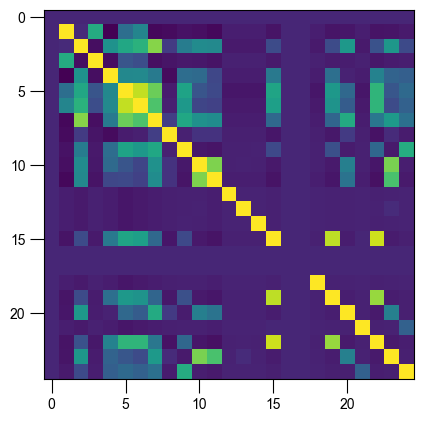

In [ ]:
plt.imshow(cell_cell_corr)

In [ ]:
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr]

In [ ]:
cell_cell_corr

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.        ,  1.        ,  0.01116953,  0.56821694, -0.12023599,
         0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
        -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
        -0.06208842,  0.        ,  0.        , -0.02613016, -0.05497113,
        -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532]),
 array([ 0.        ,  0.01116953,  1.        , -0.08083755,  0.45048596,
         0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
         0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
         0.13721005,  0.        ,  0.        , -0.03868751,  0.13441067,
         0.47694817, -0.03868751,  0.1629623 ,  0.47242736,  0.12959589]),
 array([ 0.        ,  0.56821694, -0.08083755,  1.        , -0.07926295,
         0.17442978,  0.14347369, -0.07502857, -0.05531755, -0.04206299,
  

In [ ]:
cell_cell_corr=np.hstack([np.array(corr) for corr in cell_cell_corr])

In [ ]:
cell_cell_corr

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.01116953,  0.56821694, -0.12023599,
        0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
       -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
       -0.06208842,  0.        ,  0.        , -0.02613016, -0.05497113,
       -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532,
        0.        ,  0.01116953,  1.        , -0.08083755,  0.45048596,
        0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
        0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
        0.13721005,  0.        ,  0.        , -0.03868751,  0.13

In [ ]:
cell_cell_corr.shape

(625,)

In [ ]:
cell_cell_corr=np.vstack([np.array(corr) for corr in cell_cell_corr])

In [ ]:
cell_cell_corr.shape

(625, 1)

In [ ]:
len([np.array(corr) for corr in cell_cell_corr])

625

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
cell_cell_corr=np.vstack([np.array(corr) for corr in cell_cell_corr])

<ipython-input-92-f3816b65b723>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
len([np.array(corr) for corr in cell_cell_corr])

3

In [ ]:
cell_cell_corr=np.hstack([np.array(corr) for corr in cell_cell_corr])

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr]

In [ ]:
cell_cell_corr

[array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan],
        [        nan,  1.        ,  0.01116953,  0.56821694, -0.12023599,
          0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
         -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
         -0.06208842,         nan,         nan, -0.02613016, -0.05497113,
         -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532],
        [        nan,  0.01116953,  1.        , -0.08083755,  0.45048596,
          0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
          0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
          0.13721005,         nan,  

In [ ]:
cell_cell_corr[np.isnan(cell_cell_corr)]=0

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

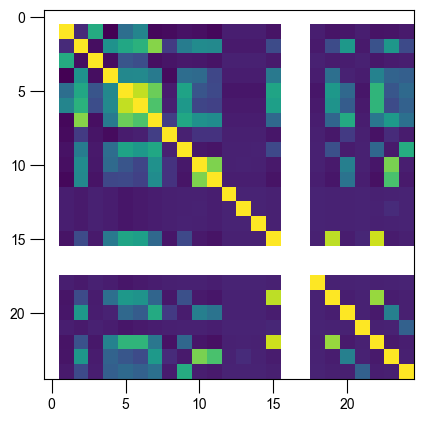

In [ ]:
plt.imshow(cell_cell_corr[0])

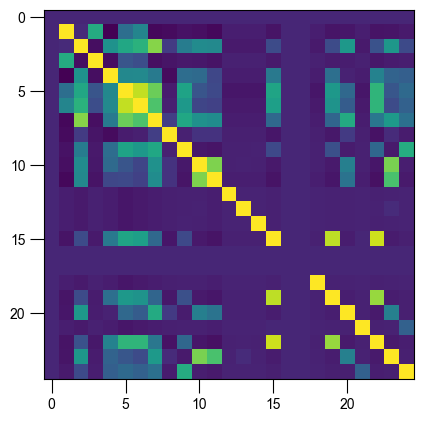

In [ ]:
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr][0]
cell_cell_corr[np.isnan(cell_cell_corr)]=0
plt.imshow(cell_cell_corr)

In [ ]:
cell_cell_corr

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.01116953,  0.56821694, -0.12023599,
         0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
        -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
        -0.06208842,  0.        ,  0.        , -0.02613016, -0.05497113,
        -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532],
       [ 0.        ,  0.01116953,  1.        , -0.08083755,  0.45048596,
         0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
         0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
         0.13721005,  0.        ,  0.        , -0

In [ ]:
cell_cell_corr=np.hstack([np.array(corr) for corr in cell_cell_corr][0])

In [ ]:
cell_cell_corr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
cell_cell_corr=np.hstack([np.array(corr) for corr in cell_cell_corr])

In [ ]:
cell_cell_corr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
cell_cell_corr=np.hstack([np.array(corr) for corr in cell_cell_corr])

<ipython-input-105-46a4aaadc021>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]

<ipython-input-106-6461fb068382>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


In [ ]:
scipy.linalg.block_diag(cell_cell_corr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

TypeError: Invalid shape (625,) for image data

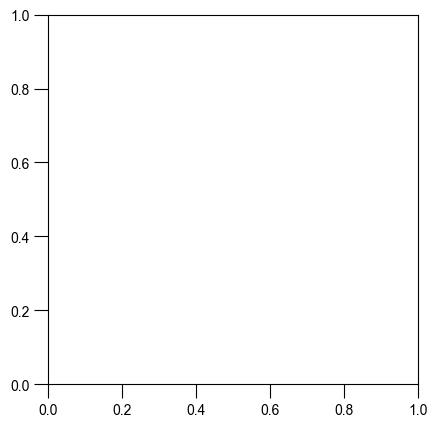

In [ ]:
cell_cell_corr=np.hstack([np.array(corr) for corr in cell_cell_corr][0])
cell_cell_corr[np.isnan(cell_cell_corr)]=0
plt.imshow(cell_cell_corr)

In [ ]:
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr][1]
cell_cell_corr[np.isnan(cell_cell_corr)]=0

In [ ]:
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr][1]
cell_cell_corr[np.isnan(cell_cell_corr)]=0
plt.imshow(cell_cell_corr)

TypeError: iteration over a 0-d array

<ipython-input-111-ca5ac9936c68>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


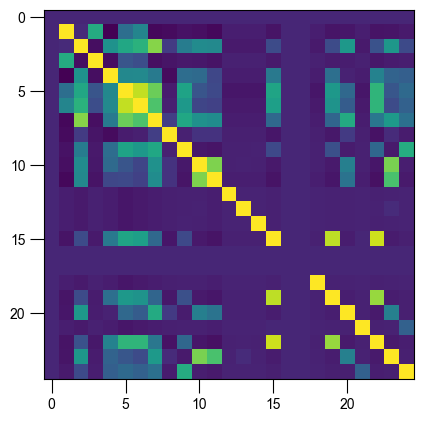

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr][0]
cell_cell_corr[np.isnan(cell_cell_corr)]=0
plt.imshow(cell_cell_corr)

<ipython-input-112-18987e18c42e>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


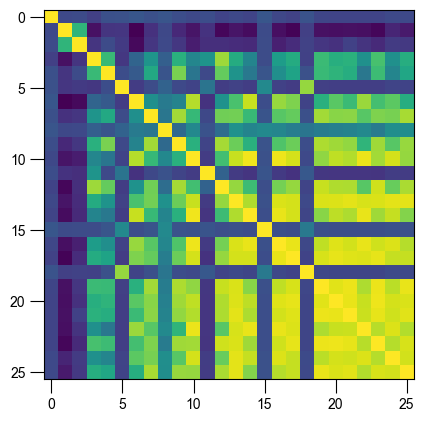

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
cell_cell_corr=[np.array(corr) for corr in cell_cell_corr][1]
cell_cell_corr[np.isnan(cell_cell_corr)]=0
plt.imshow(cell_cell_corr)

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]

<ipython-input-113-6461fb068382>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


In [ ]:
scipy.linalg.block_diag(cell_cell_corr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
cell_cell_corr = [np.nan_to_num(np.array(corr, dtype=float)) for corr in cell_cell_corr]

<ipython-input-115-f89e99f71c62>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


In [ ]:
scipy.linalg.block_diag(cell_cell_corr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
cell_cell_corr

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.01116953,  0.56821694, -0.12023599,
          0.28561715,  0.39025933, -0.09720901, -0.08859118, -0.06736397,
         -0.07391335, -0.09761494, -0.02613016, -0.02613016, -0.02613016,
         -0.06208842,  0.        ,  0.        , -0.02613016, -0.05497113,
         -0.05158393, -0.02613016, -0.06231739, -0.05633492, -0.03889532],
        [ 0.        ,  0.01116953,  1.        , -0.08083755,  0.45048596,
          0.55268175,  0.59571144,  0.79591172,  0.07386451,  0.35145734,
          0.42163729,  0.40583678, -0.03868751, -0.03868751, -0.03868751,
          0.13721005,  0.        ,  

In [ ]:
len(cell_cell_corr)

3

In [ ]:
cell_cell_corr[0].shape

(25, 25)

In [ ]:
cell_cell_corr = np.stack([np.nan_to_num(np.array(corr, dtype=float)) for corr in cell_cell_corr])

ValueError: all input arrays must have the same shape

In [ ]:
cell_cell_corr = np.concatenate([np.nan_to_num(np.array(corr, dtype=float)) for corr in cell_cell_corr])

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
corr = np.append(cell_cell_corr)

TypeError: append() missing 1 required positional argument: 'values'

In [ ]:
corr = np.append(cell_cell_corr[0],cell_cell_corr[1])

In [ ]:
corr.shape

(1301,)

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]
cell_cell_corr = [np.nan_to_num(np.array(corr, dtype=float)) for corr in cell_cell_corr]

<ipython-input-125-f89e99f71c62>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


In [ ]:
corr.shape

(1301,)

In [ ]:
tcs_all

[array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [2.47490891, 2.72429311, 3.17763233, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.61252099, 1.1715197 , 0.56929207, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [1.73391552, 3.32941137, 3.81567048, ..., 1.7570871 ,
          2.09349869, 0.        ],
         [5.27671399, 5.04978822, 4.81896923, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.28906797,
          0.29767804, 0.

In [ ]:
np.vstack(tcs_all)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 26

In [ ]:
np.hstack(tcs_all)

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [2.47490891, 2.72429311, 3.17763233, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [4.21078388, 4.00144911, 3.40699804, ..., 2.91651654,
         3.34278488, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.73391552, 3.32941137, 3.81567048, ..., 1.7570871 ,
         2.09349869, 0.        ],
        [5.27671399, 5.04978822, 4.81896923, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [3.1523427 , 2.61033843, 2.28563474, ..., 2.16019557,
         1.94662021, 0.        ],
        [0. 

In [ ]:
np.hstack(tcs_all).shape

(324, 60, 150)

In [ ]:
cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]

<ipython-input-131-3a3343e43a02>:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cell_cell_corr = [[[scipy.stats.pearsonr(tcs_all[ep][cll,tr1],tcs_all[ep][cll,tr2])[0] for tr1 in range(tcs_all[ep].shape[1])] for tr2 in range(tcs_all[ep].shape[1])] for ep in range(len(tcs_all))]


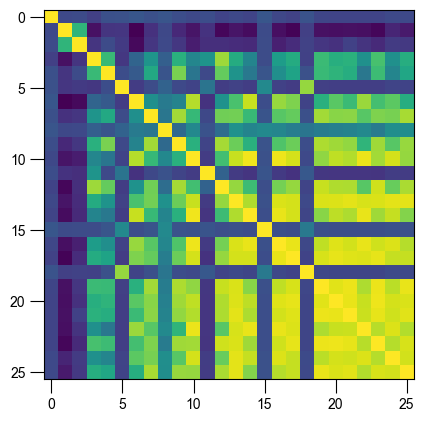

In [ ]:
cell_cell_corr = [np.nan_to_num(np.array(corr, dtype=float)) for corr in cell_cell_corr]

cell_cell_corr=[np.array(corr) for corr in cell_cell_corr][1]
cell_cell_corr[np.isnan(cell_cell_corr)]=0
plt.imshow(cell_cell_corr)

In [ ]:
cell_cell_corr = []

for ep in range(len(tcs_all)):
    n_trials = tcs_all[ep].shape[1]  # trials in this epoch
    corr_mat = np.zeros((n_trials, n_trials))

    for tr1 in range(n_trials):
        for tr2 in range(n_trials):
            r, _ = scipy.stats.pearsonr(tcs_all[ep][cll, tr1], tcs_all[ep][cll, tr2])
            corr_mat[tr1, tr2] = r

    # Replace NaN with 0
    corr_mat = np.nan_to_num(corr_mat)
    cell_cell_corr.append(corr_mat)

# Now make one big square matrix
big_corr = block_diag(*cell_cell_corr)



<ipython-input-133-513a14d794db>:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = scipy.stats.pearsonr(tcs_all[ep][cll, tr1], tcs_all[ep][cll, tr2])


NameError: name 'block_diag' is not defined

In [ ]:
cell_cell_corr = []

for ep in range(len(tcs_all)):
    n_trials = tcs_all[ep].shape[1]  # trials in this epoch
    corr_mat = np.zeros((n_trials, n_trials))

    for tr1 in range(n_trials):
        for tr2 in range(n_trials):
            r, _ = scipy.stats.pearsonr(tcs_all[ep][cll, tr1], tcs_all[ep][cll, tr2])
            corr_mat[tr1, tr2] = r

    # Replace NaN with 0
    corr_mat = np.nan_to_num(corr_mat)
    cell_cell_corr.append(corr_mat)

# Now make one big square matrix
big_corr = scipy.linalg.block_diag(*cell_cell_corr)



<ipython-input-134-9b1c5cf0b35a>:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = scipy.stats.pearsonr(tcs_all[ep][cll, tr1], tcs_all[ep][cll, tr2])


In [ ]:
big_corr.shape

(60, 60)

<ipython-input-136-23d11422d35d>:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = scipy.stats.pearsonr(tcs_all[ep][cll, tr1], tcs_all[ep][cll, tr2])


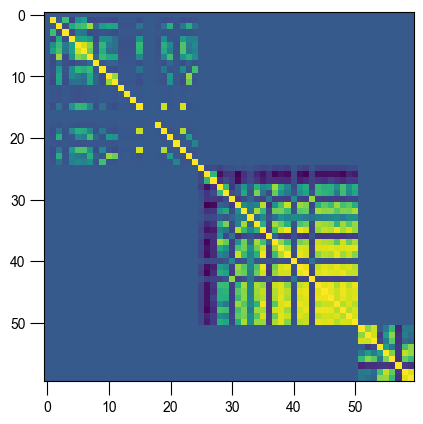

In [ ]:
cell_cell_corr = []
for ep in range(len(tcs_all)):
   n_trials = tcs_all[ep].shape[1]  # trials in this epoch
   corr_mat = np.zeros((n_trials, n_trials))

   for tr1 in range(n_trials):
      for tr2 in range(n_trials):
         r, _ = scipy.stats.pearsonr(tcs_all[ep][cll, tr1], tcs_all[ep][cll, tr2])
         corr_mat[tr1, tr2] = r

   # Replace NaN with 0
   corr_mat = np.nan_to_num(corr_mat)
   cell_cell_corr.append(corr_mat)
# Now make one big square matrix
big_corr = scipy.linalg.block_diag(*cell_cell_corr)
plt.imshow(big_corr)

In [ ]:
cll=0
cell_cell_corr = []
tcs_all_ep=np.hstack(tcs_all)
n_trials = tcs_all_ep.shape[1]  # trials in this epoch
corr_mat = np.zeros((n_trials, n_trials))

for tr1 in range(n_trials):
   for tr2 in range(n_trials):
      r, _ = scipy.stats.pearsonr(tcs_all_ep[cll, tr1], tcs_all_ep[cll, tr2])
      corr_mat[tr1, tr2] = r

<ipython-input-137-78c7e8ce7f4d>:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = scipy.stats.pearsonr(tcs_all_ep[cll, tr1], tcs_all_ep[cll, tr2])


In [ ]:
cll

0

In [ ]:
corr_mat

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  1.        ,  0.01116953, ..., -0.13139937,
         0.54663781,  0.72327191],
       [        nan,  0.01116953,  1.        , ...,  0.76365531,
        -0.13739721, -0.13056173],
       ...,
       [        nan, -0.13139937,  0.76365531, ...,  1.        ,
        -0.16513076, -0.19473219],
       [        nan,  0.54663781, -0.13739721, ..., -0.16513076,
         1.        ,  0.92380621],
       [        nan,  0.72327191, -0.13056173, ..., -0.19473219,
         0.92380621,  1.        ]])

In [ ]:
corr_mat = np.nan_to_num(corr_mat)

In [ ]:
corr_mat.shape

(60, 60)

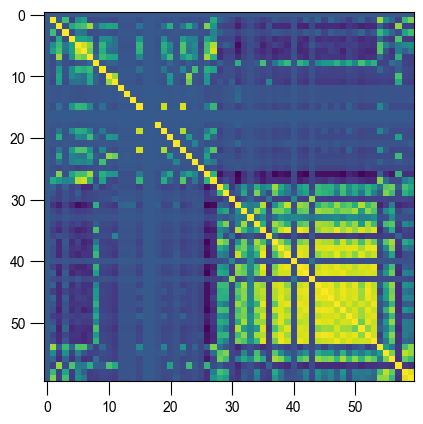

In [ ]:
plt.imshow(corr_mat)

In [ ]:
trialstates=np.hstack(trialstates)

In [ ]:
trialstates.shape

(66,)

In [ ]:
np.hstack(tcs_all).shape

(324, 60, 150)

In [ ]:
trialstates

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
        1.])

In [ ]:
trialstates, licks_all, tcs_all, coms_all, ypos_max_all_ep, vels_all =make_tuning_curves_time_trial_by_trial_w_darktime(eps, rewlocs, rewsize, lick, ybinned, time, Fc3, trialnum, rewards, forwardvel, scalingf,bins=150)

<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: invalid value encountered in scalar divide
  frac[i] = (spatial_act_cum_sum[i, binn[i]] - mid_sum[i]) / spatial_act_cum_sum[i, binn[i]]
<ipython-input-36-1b0ca0d94732>:813: RuntimeWarning: in